<a href="https://colab.research.google.com/github/cyndwith/DeepGC/blob/master/ICNet/ICNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
# Google tutorial on Image segmentation
%tensorflow_version 2.x

In [0]:
import os
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from IPython.display import clear_output

# import matplotlib.pyplot as plt
# import tensorflow_datasets as tfds

# Tensorflow 2.0 has eager execution by default
#tf.compat.v1.enable_eager_execution()
tf.executing_eagerly()
tf.__version__

tfds.disable_progress_bar()

In [4]:
print(tf.__version__)
print(tf.executing_eagerly())
tf.config.experimental_run_functions_eagerly(True)

2.2.0-rc2
True


In [5]:
!wget https://github.com/shubham0204/Dataset_Archives/blob/master/cityscape_images.zip?raw=true -O cityscape_images.zip
!unzip cityscape_images.zip

--2020-04-08 22:54:34--  https://github.com/shubham0204/Dataset_Archives/blob/master/cityscape_images.zip?raw=true
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/shubham0204/Dataset_Archives/raw/master/cityscape_images.zip [following]
--2020-04-08 22:54:35--  https://github.com/shubham0204/Dataset_Archives/raw/master/cityscape_images.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/shubham0204/Dataset_Archives/master/cityscape_images.zip [following]
--2020-04-08 22:54:35--  https://raw.githubusercontent.com/shubham0204/Dataset_Archives/master/cityscape_images.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.

In [6]:
from PIL import Image , ImageOps
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.utils import to_categorical

num_classes = 20

x = list()
y = list()

num_images = 400 

image_dir = 'cityscape_images/images'
image_filenames = os.listdir( image_dir )

cityscapes_colormap = np.array([
                        [128,  64, 128],
                        [244,  35, 232],
                        [ 70,  70,  70],
                        [102, 102, 156],
                        [190, 153, 153],
                        [153, 153, 153],
                        [250, 170,  30],
                        [220, 220,   0],
                        [107, 142,  35],
                        [152, 251, 152],
                        [ 70, 130, 180],
                        [220,  20,  60],
                        [255,   0,   0],
                        [  0,   0, 142],
                        [  0,   0,  70],
                        [  0,  60, 100],
                        [  0,  80, 100],
                        [  0,   0, 230],
                        [119,  11,  32],
                        [  0,   0,   0]], dtype=np.uint8)

def format_label(pixel):
  err = 25.
  if np.logical_and((pixel >= cityscapes_colormap[0] - err), (pixel <= cityscapes_colormap[0] + err)).all(): # road  
    return np.array([1])
  elif np.logical_and((pixel >= cityscapes_colormap[13] - err), (pixel <= cityscapes_colormap[13] + err)).all(): # car
    return np.array([2])
  elif np.logical_and((pixel >= cityscapes_colormap[10] - err), (pixel <= cityscapes_colormap[10] + err)).all(): #sky
    return np.array([3])
  else:
    return np.array([0])

for filename in image_filenames[0:100]:
  image = Image.open(os.path.join(image_dir, filename))
  x.append(np.asarray(ImageOps.crop(image , ( 0 , 0 , 256 , 0 ))))
  y.append(np.asarray(ImageOps.crop(image, (256, 0, 0, 0))))

x = np.array(x)/255
y = np.array(y)

num_images = len(x)
train_features, test_features, train_olabels, test_olabels = train_test_split(np.array(x), np.array(y), test_size=0.4)

print(train_features.shape)
print(train_olabels.shape)

train_labels = np.apply_along_axis(format_label , axis=3 , arr=train_olabels) 
test_labels  = np.apply_along_axis(format_label , axis=3 , arr=test_olabels) 

print(train_labels.shape)
print(test_labels.shape)

Using TensorFlow backend.


(60, 256, 256, 3)
(60, 256, 256, 3)
(60, 256, 256, 1)
(40, 256, 256, 1)


In [7]:
TRAIN_LENGTH = num_images 
BATCH_SIZE = 8
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = 10 * TRAIN_LENGTH // BATCH_SIZE

train_dataset = tf.data.Dataset.from_tensor_slices((train_features, train_labels))
train_dataset = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder = False).repeat()

test_dataset = tf.data.Dataset.from_tensor_slices((test_features , test_labels))
test_dataset = test_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder = False).repeat()

print(train_dataset)
print(test_dataset)

print('TRAIN_LENGHT:', TRAIN_LENGTH)
print('BATCH_SIZE:', BATCH_SIZE)
print('BUFFER_SIZE:', BUFFER_SIZE)
print('STEPS_PER_EPOCH:', STEPS_PER_EPOCH)

print(train_dataset)


<RepeatDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float64, tf.int64)>
<RepeatDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float64, tf.int64)>
TRAIN_LENGHT: 100
BATCH_SIZE: 8
BUFFER_SIZE: 1000
STEPS_PER_EPOCH: 125
<RepeatDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float64, tf.int64)>


(256, 256, 1)


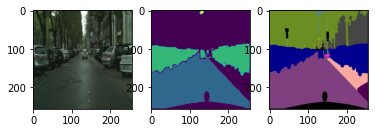

In [8]:
plt.subplot(1,3,1)
plt.imshow(train_features[0])
plt.subplot(1,3,2)
plt.imshow(tf.keras.preprocessing.image.array_to_img(train_labels[0]))
plt.subplot(1,3,3)
plt.imshow(train_olabels[0])


In [9]:
# pre processing operations
# labeled mask: {0, 1, 2, 3} 
IMAGE_SIZE = 256
#@tf.function
def load_images_train(image, labels):
  input_image  = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
  input_image  = (input_image - 127.5) / 255
  #input_labels = tf.image.resize(labels, (256, 256))
  labels_4  = tf.image.resize(labels, (64, 64))
  labels_8  = tf.image.resize(labels, (32,32))
  labels_16 = tf.image.resize(labels, (16, 16))

  return input_image, (labels_4, labels_8, labels_16)

def load_images_test(image, labels):
  input_image  = tf.image.resize(image, (256, 256))
  input_image  = (input_image - 127.5) / 255
  #input_labels = tf.image.resize(labels, (256, 256))
  labels_4  = tf.image.resize(labels, (64, 64))
  labels_8  = tf.image.resize(labels, (32,32))
  labels_16 = tf.image.resize(labels, (16, 16))
  return input_image, (labels_4, labels_8, labels_16)

train_dataset  = train_dataset.map(load_images_train)
test_dataset   = test_dataset.map(load_images_test)

print(train_dataset)
print(test_dataset)

<MapDataset shapes: ((None, 256, 256, 3), ((None, 64, 64, 1), (None, 32, 32, 1), (None, 16, 16, 1))), types: (tf.float32, (tf.float32, tf.float32, tf.float32))>
<MapDataset shapes: ((None, 256, 256, 3), ((None, 64, 64, 1), (None, 32, 32, 1), (None, 16, 16, 1))), types: (tf.float32, (tf.float32, tf.float32, tf.float32))>


'\ntrain_images  = train_images.map(load_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)\ntrain_labels  = train_images.map(load_labels, num_parallel_calls=tf.data.experimental.AUTOTUNE)\ntest_images   = test_images.map(load_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)\ntest_labels   = test_images.map(load_labels, num_parallel_calls=tf.data.experimental.AUTOTUNE)\n\nprint(train_images)\nprint(train_labels)\nprint(test_images)\nprint(test_labels)\n'

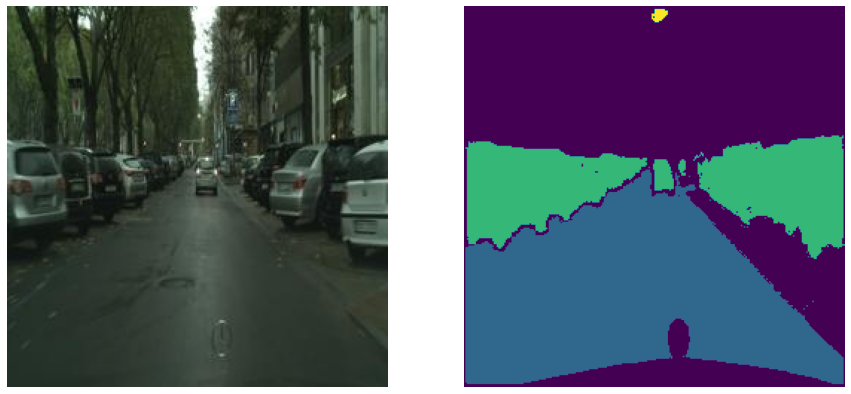

(1, 256, 256, 3)
(8, 256, 256, 3)
(8, 64, 64, 1)
(8, 32, 32, 1)
(8, 16, 16, 1)


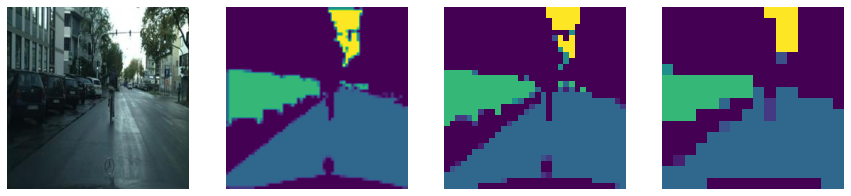

In [10]:
# show sample image from dataset
def display(display_list):
  plt.figure(figsize=(15, 15))
  #title = ['Input Image',  'True Mask', 'Predicted Mask']
  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    #plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

sample_image = []
sample_label = []
sample_data = train_dataset.take(1)
sample_image = tf.expand_dims(train_features[0], axis=0)
sample_label = tf.expand_dims(train_labels[0], axis=0)
display([tf.squeeze(sample_image), (sample_label[0])])

print(sample_image.shape)

for image, (label_4, label_8, label_16) in train_dataset.take(1):
  print(image.shape)
  print(label_4.shape)
  print(label_8.shape)
  print(label_16.shape)
  display([image[0], label_4[0], label_8[0], label_16[0]])

In [26]:
import tensorflow.keras.layers as tfkl

IMAGE_WIDTH = 256
IMAGE_HEIGHT = 256

def ICNet_model(input_size=(IMAGE_WIDTH, IMAGE_HEIGHT, 3), num_classes=4, train = False):
  inp = tfkl.Input(input_size)
  # (1/2)
  #n1_resize = tfkl.Lambda(lambda x: tf.image.resize(inp, size=(int(inp.shape[1])//2, int(inp.shape[2])//2)), name='n1_resize')(inp)
  n1_resize = tfkl.Conv2D(3, 2, strides=2, padding='same', name='n1_resize')(inp)
  # Output : input_size / 2
  n1_conv  = tfkl.Conv2D(32, 3, strides=2, padding='same', activation='relu', name='n1_conv1_3x3_s2')(n1_resize)
  n1_conv  = tfkl.BatchNormalization(name='n1_conv2_3x3_s2_bn')(n1_conv)
  # Output : input_size / 4
  n1_conv  = tfkl.Conv2D(32, 3, padding='same', activation='relu', name='n1_conv3_3x3')(n1_conv)
  n1_conv  = tfkl.BatchNormalization(name='n1_conv4_3x3_bn')(n1_conv)
  n1_conv  = tfkl.Conv2D(64, 3, padding='same', activation='relu', name='n1_conv5_3x3')(n1_conv)
  n1_conv  = tfkl.BatchNormalization(name='n1_conv5_3x3_bn')(n1_conv)
  n1_pool  = tfkl.MaxPooling2D(pool_size=3, strides=2, name='n1_pool_3x3_s2')(n1_conv)
  # Output : input_size / 8
  n1_conv  = tfkl.Conv2D(128, 1, name='n1_conv6_1x1')(n1_pool)
  n1_conv  = tfkl.BatchNormalization(name='n1_conv6_1x1_bn')(n1_conv)
  
  n2_conv = tfkl.Conv2D(32, 1, activation='relu', name='n2_conv1_1x1')(n1_pool)
  n2_conv = tfkl.BatchNormalization(name='n2_conv1_1x1_bn')(n2_conv)
  n2_pad  = tfkl.ZeroPadding2D(name='n2_pad')(n2_conv)
  n2_conv = tfkl.Conv2D(32, 3, activation='relu', name='n2_conv2_3x3')(n2_pad)
  n2_conv = tfkl.BatchNormalization(name='n2_conv2_3x3_bn')(n2_conv)
  n2_conv = tfkl.Conv2D(128, 1, name='n2_conv3_1x1')(n2_conv)
  n2_conv = tfkl.BatchNormalization(name='n2_conv3_1x1_bn')(n2_conv)
  n2_add  = tfkl.Add(name='n2_add')([n1_conv,n2_conv])
  n2_act  = tfkl.Activation('relu', name='n2_act')(n2_add)

  n3_conv = tfkl.Conv2D(32, 1, activation='relu', name='n3_conv1_1x1')(n2_act)
  n3_conv = tfkl.BatchNormalization(name='n3_conv1_1x1_bn')(n3_conv)
  n3_pad  = tfkl.ZeroPadding2D(name='n3_pad')(n3_conv)
  n3_conv = tfkl.Conv2D(32, 3, activation='relu', name='n3_conv2_3x3')(n3_pad)
  n3_conv = tfkl.BatchNormalization(name='n3_conv2_3x3_bn')(n3_conv)
  n3_conv = tfkl.Conv2D(128, 1, name='n3_conv3_1x1')(n3_conv)
  n3_conv = tfkl.BatchNormalization(name='n3_conv3_1x1_bn')(n3_conv)
  n3_add  = tfkl.Add(name='n3_add')([n3_conv,n2_act])
  n3_act  = tfkl.Activation('relu', name='n3_act')(n3_add)

  n4_conv = tfkl.Conv2D(32, 1, activation='relu', name='n4_conv1_1x1')(n3_act)
  n4_conv = tfkl.BatchNormalization(name='n4_conv1_1x1_bn')(n4_conv)
  n4_pad  = tfkl.ZeroPadding2D(name='n4_pad')(n4_conv)
  n4_conv = tfkl.Conv2D(32, 3, activation='relu', name='n4_conv2_3x3')(n4_pad)
  n4_conv = tfkl.BatchNormalization(name='n4_conv2_3x3_bn')(n4_conv)
  n4_conv = tfkl.Conv2D(128, 1, name='n4_conv3_1x1')(n4_conv)
  n4_conv = tfkl.BatchNormalization(name='n4_conv3_1x1_bn')(n4_conv)
  n4_add  = tfkl.Add(name='n4_add')([n4_conv,n3_act])
  n4_act  = tfkl.Activation('relu', name='n4_act')(n4_add)

  n5_conv = tfkl.Conv2D(256, 1, strides=2, name='n5_conv1_1x1')(n4_act)
  n5_conv_bn = tfkl.BatchNormalization(name='n5_conv1_1x1_bn')(n5_conv)
  n5_conv = tfkl.Conv2D(64, 1, strides=2, activation='relu', name='n5_conv2_1x1_s2')(n4_act)
  n5_conv = tfkl.BatchNormalization(name='n5_conv2_1x1_s2_bn')(n5_conv)
  n5_pad  = tfkl.ZeroPadding2D(name='n5_pad')(n5_conv)
  n5_conv = tfkl.Conv2D(64, 3, activation='relu', name='n5_conv3_3x3')(n5_pad)
  n5_conv = tfkl.BatchNormalization(name='n5_conv3_3x3_bn')(n5_conv)
  n5_conv = tfkl.Conv2D(256, 1, name='n5_conv4_1x1')(n5_conv)
  n5_conv = tfkl.BatchNormalization(name='n5_conv4_1x1_bn')(n5_conv)
  n5_add  = tfkl.Add(name='n5_add')([n5_conv_bn,n5_conv])
  n5_act  = tfkl.Activation('relu', name='n5_act')(n5_add)

  # (1/4)
  #n6_resize = tfkl.Lambda(lambda x: tf.image.resize(x, size=(int(x.shape[1])//2, int(x.shape[2])//2)), name='n6_resize')(n5_act)
  n6_resize = tfkl.Conv2D(256, 2, strides=2, padding='same', name='n6_resize')(n5_act)
  n6_conv = tfkl.Conv2D(64, 1, activation='relu', name='n6_conv1_1x1')(n6_resize)
  n6_conv = tfkl.BatchNormalization(name='n6_conv1_1x1_bn')(n6_conv)
  n6_pad  = tfkl.ZeroPadding2D(name='n6_pad')(n6_conv)
  n6_conv = tfkl.Conv2D(64, 3, activation='relu', name='n6_conv2_3x3')(n6_pad)
  n6_conv = tfkl.BatchNormalization(name='n6_conv2_3x3_bn')(n6_conv)
  n6_conv = tfkl.Conv2D(256, 1, name='n6_conv3_1x1')(n6_conv)
  n6_conv = tfkl.BatchNormalization(name='n6_conv3_1x1_bn')(n6_conv)
  n6_add  = tfkl.Add(name='n6_add')([n6_conv,n6_resize])
  n6_act  = tfkl.Activation('relu', name='n6_act')(n6_add)

  n7_conv = tfkl.Conv2D(64, 1, activation='relu', name='n7_conv1_1x1')(n6_act)
  n7_conv = tfkl.BatchNormalization(name='n7_conv1_1x1_bn')(n7_conv)
  n7_pad  = tfkl.ZeroPadding2D(name='n7_pad')(n7_conv)
  n7_conv = tfkl.Conv2D(64, 3, activation='relu', name='n7_conv2_3x3')(n7_pad)
  n7_conv = tfkl.BatchNormalization(name='n7_conv2_3x3_bn')(n7_conv)
  n7_conv = tfkl.Conv2D(256, 1, name='n7_conv3_1x1')(n7_conv)
  n7_conv = tfkl.BatchNormalization(name='n7_conv3_1x1_bn')(n7_conv)
  n7_add  = tfkl.Add(name='n7_add')([n7_conv,n6_act])
  n7_act  = tfkl.Activation('relu', name='n7_act')(n7_add)

  n8_conv = tfkl.Conv2D(64, 1, activation='relu', name='n8_conv1_1x1')(n7_act)
  n8_conv = tfkl.BatchNormalization(name='n8_conv1_1x1_bn')(n8_conv)
  n8_pad  = tfkl.ZeroPadding2D(name='n8_pad')(n8_conv)
  n8_conv = tfkl.Conv2D(64, 3, activation='relu', name='n8_conv2_3x3')(n8_pad)
  n8_conv = tfkl.BatchNormalization(name='n8_conv2_3x3_bn')(n8_conv)
  n8_conv = tfkl.Conv2D(256, 1, name='n8_conv3_1x1')(n8_conv)
  n8_conv = tfkl.BatchNormalization(name='n8_conv3_1x1_bn')(n8_conv)
  n8_add  = tfkl.Add(name='n8_add')([n8_conv,n7_act])
  n8_act  = tfkl.Activation('relu', name='n8_act')(n8_add)

  n9_conv = tfkl.Conv2D(512, 1, name='n9_conv1_1x1')(n8_act)
  n9_conv_bn = tfkl.BatchNormalization(name='n9_conv1_1x1_bn')(n9_conv)
  n9_conv = tfkl.Conv2D(128, 1, activation='relu', name='n9_conv2_1x1')(n8_act)
  n9_conv = tfkl.BatchNormalization(name='n9_conv2_1x1_bn')(n9_conv)
  n9_pad  = tfkl.ZeroPadding2D(padding=2, name='n9_pad')(n9_conv)
  n9_conv = tfkl.Conv2D(128, 3, dilation_rate=2, activation='relu', name='n9_conv3_3x3')(n9_pad)
  n9_conv = tfkl.BatchNormalization(name='n9_conv3_3x3_bn')(n9_conv)
  n9_conv = tfkl.Conv2D(512, 1, name='n9_conv4_1x1')(n9_conv)
  n9_conv = tfkl.BatchNormalization(name='n9_conv4_1x1_bn')(n9_conv)
  n9_add  = tfkl.Add(name='n9_add')([n9_conv_bn,n9_conv])
  n9_act  = tfkl.Activation('relu', name='n9_act')(n9_add)

  n10_conv = tfkl.Conv2D(128, 1, activation='relu', name='n10_conv1_1x1')(n9_act)
  n10_conv = tfkl.BatchNormalization(name='n10_conv1_1x1_bn')(n10_conv)
  n10_pad  = tfkl.ZeroPadding2D(padding=2, name='n10_pad')(n10_conv)
  n10_conv = tfkl.Conv2D(128, 3, dilation_rate=2, activation='relu', name='n10_conv2_3x3_d2')(n10_pad)
  n10_conv = tfkl.BatchNormalization(name='n10_conv2_3x3_d2_bn')(n10_conv)
  n10_conv = tfkl.Conv2D(512, 1, name='n10_conv3_1x1')(n10_conv)
  n10_conv = tfkl.BatchNormalization(name='n10_conv3_1x1_bn')(n10_conv)
  n10_add  = tfkl.Add(name='n10_add')([n10_conv,n9_act])
  n10_act  = tfkl.Activation('relu', name='n10_act')(n10_add)

  n11_conv = tfkl.Conv2D(128, 1, activation='relu', name='n11_conv1_1x1')(n10_act)
  n11_conv = tfkl.BatchNormalization(name='n11_conv1_1x1_bn')(n11_conv)
  n11_pad  = tfkl.ZeroPadding2D(padding=2, name='n11_pad')(n11_conv)
  n11_conv = tfkl.Conv2D(128, 3, dilation_rate=2, activation='relu', name='n11_conv2_3x3')(n11_pad)
  n11_conv = tfkl.BatchNormalization(name='n11_conv2_3x3_bn')(n11_conv)
  n11_conv = tfkl.Conv2D(512, 1, name='n11_conv3_1x1')(n11_conv)
  n11_conv = tfkl.BatchNormalization(name='n11_conv3_1x1_bn')(n11_conv)
  n11_add  = tfkl.Add(name='n11_add')([n11_conv,n10_act])
  n11_act  = tfkl.Activation('relu', name='n11_act')(n11_add)

  n12_conv = tfkl.Conv2D(128, 1, activation='relu', name='n12_conv1_1x1')(n11_act)
  n12_conv = tfkl.BatchNormalization(name='n12_conv1_1x1_bn')(n12_conv)
  n12_pad  = tfkl.ZeroPadding2D(padding=2, name='n12_pad')(n12_conv)
  n12_conv = tfkl.Conv2D(128, 3, dilation_rate=2, activation='relu', name='n12_conv2_3x3')(n12_pad)
  n12_conv = tfkl.BatchNormalization(name='n12_conv2_3x3_bn')(n12_conv)
  n12_conv = tfkl.Conv2D(512, 1, name='n12_conv3_1x1')(n12_conv)
  n12_conv = tfkl.BatchNormalization(name='n12_conv3_1x1_bn')(n12_conv)
  n12_add  = tfkl.Add(name='n12_add')([n12_conv,n11_act])
  n12_act  = tfkl.Activation('relu', name='n12_act')(n12_add)

  n13_conv = tfkl.Conv2D(128, 1, activation='relu', name='n13_conv1_1x1')(n12_act)
  n13_conv = tfkl.BatchNormalization(name='n13_conv1_1x1_bn')(n13_conv)
  n13_pad  = tfkl.ZeroPadding2D(padding=2, name='n13_pad')(n13_conv)
  n13_conv = tfkl.Conv2D(128, 3, dilation_rate=2, activation='relu', name='n13_conv2_3x3')(n13_pad)
  n13_conv = tfkl.BatchNormalization(name='n13_conv2_3x3_bn')(n13_conv)
  n13_conv = tfkl.Conv2D(512, 1, name='n13_conv3_1x1')(n13_conv)
  n13_conv = tfkl.BatchNormalization(name='n13_conv3_1x1_bn')(n13_conv)
  n13_add  = tfkl.Add(name='n13_add')([n13_conv,n12_act])
  n13_act  = tfkl.Activation('relu', name='n13_act')(n13_add)

  n14_conv = tfkl.Conv2D(128, 1, activation='relu', name='n14_conv1_1x1')(n13_act)
  n14_conv = tfkl.BatchNormalization(name='n14_conv1_1x1_bn')(n14_conv)
  n14_pad  = tfkl.ZeroPadding2D(padding=2, name='n14_pad')(n14_conv)
  n14_conv = tfkl.Conv2D(128, 3, dilation_rate=2, activation='relu', name='n14_conv2_3x3')(n14_pad)
  n14_conv = tfkl.BatchNormalization(name='n14_conv2_3x3_bn')(n14_conv)
  n14_conv = tfkl.Conv2D(512, 1, name='n14_conv3_1x1')(n14_conv)
  n14_conv = tfkl.BatchNormalization(name='n14_conv3_1x1_bn')(n14_conv)
  n14_add  = tfkl.Add(name='n14_add')([n14_conv,n13_act])
  n14_act  = tfkl.Activation('relu', name='n14_act')(n14_add)

  n15_conv = tfkl.Conv2D(1024, 1, name='n15_conv1_1x1')(n14_act)
  n15_conv_bn = tfkl.BatchNormalization(name='n15_conv1_1x1_bn')(n15_conv)
  n15_conv = tfkl.Conv2D(256, 1, activation='relu', name='n15_conv2_1x1')(n14_act)
  n15_conv = tfkl.BatchNormalization(name='n15_conv2_1x1_bn')(n15_conv)
  n15_pad  = tfkl.ZeroPadding2D(padding=4, name='n15_pad')(n15_conv)
  n15_conv = tfkl.Conv2D(256, 3, dilation_rate=4, activation='relu', name='n15_conv3_3x3')(n15_pad)
  n15_conv = tfkl.BatchNormalization(name='n15_conv3_3x3_bn')(n15_conv)
  n15_conv = tfkl.Conv2D(1024, 1, name='n15_conv4_1x1')(n15_conv)
  n15_conv = tfkl.BatchNormalization(name='n15_conv4_1x1_bn')(n15_conv)
  n15_add  = tfkl.Add(name='n15_add')([n15_conv_bn,n15_conv])
  n15_act  = tfkl.Activation('relu', name='n15_act')(n15_add)

  n16_conv = tfkl.Conv2D(256, 1, activation='relu', name='n16_conv1_1x1')(n15_act)
  n16_conv = tfkl.BatchNormalization(name='n16_conv1_1x1_bn')(n16_conv)
  n16_pad  = tfkl.ZeroPadding2D(padding=4, name='n16_pad')(n16_conv)
  n16_conv = tfkl.Conv2D(256, 3, dilation_rate=4, activation='relu', name='n16_conv2_3x3')(n16_pad)
  n16_conv = tfkl.BatchNormalization(name='n16_conv2_3x3_bn')(n16_conv)
  n16_conv = tfkl.Conv2D(1024, 1, name='n16_conv3_1x1')(n16_conv)
  n16_conv = tfkl.BatchNormalization(name='n16_conv3_1x1_bn')(n16_conv)
  n16_add  = tfkl.Add(name='n16_add')([n16_conv,n15_act])
  n16_act  = tfkl.Activation('relu', name='n16_act')(n16_add)

  n17_conv = tfkl.Conv2D(256, 1, activation='relu', name='n17_conv1_1x1')(n16_act)
  n17_conv = tfkl.BatchNormalization(name='n17_conv1_1x1_bn')(n17_conv)
  n17_pad  = tfkl.ZeroPadding2D(padding=4, name='n17_pad')(n17_conv)
  n17_conv = tfkl.Conv2D(256, 3, dilation_rate=4, activation='relu', name='n17_conv2_3x3')(n17_pad)
  n17_conv = tfkl.BatchNormalization(name='n17_conv2_3x3_bn')(n17_conv)
  n17_conv = tfkl.Conv2D(1024, 1, name='n17_conv3_1x1')(n17_conv)
  n17_conv = tfkl.BatchNormalization(name='n17_conv3_1x1_bn')(n17_conv)
  n17_add  = tfkl.Add(name='n17_add')([n17_conv,n16_act])
  n17_act  = tfkl.Activation('relu', name='n17_act')(n17_add)

  h, w = n17_act.shape[1:3].as_list()
  pool1 = tfkl.AveragePooling2D(pool_size=(h,w), strides=(h,w), name='n17_pool1')(n17_act)
  pool1 = tfkl.UpSampling2D(size=(int(h), int(w)), name='n17_pool1_interp')(pool1)
  
  pool2 = tfkl.AveragePooling2D(pool_size=(h/2,w/2), strides=(h//2,w//2), name='n17_pool2')(n17_act)
  pool2 = tfkl.UpSampling2D(size=(int(h/2), int(w/2)), name='n17_pool2_interp')(pool2)
  
  pool3 = tfkl.AveragePooling2D(pool_size=(h/3,w/3), strides=(h//3,w//3), name='n17_pool3')(n17_act)
  pool3 = tfkl.UpSampling2D(size=(int(h/3), int(w/3)), name='n17_pool3_interp')(pool3)
  

  pool6 = tfkl.AveragePooling2D(pool_size=(h/4,w/4), strides=(h//4,w//4), name='n17_pool6')(n17_act)
  pool6 = tfkl.UpSampling2D(size=(int(h/4), int(w/4)), name='n17_pool6_interp')(pool6)
  
  n18_add  = tfkl.Add(name='n18_add')([n17_act, pool1, pool2, pool3, pool6])
  n18_conv = tfkl.Conv2D(256, 1, activation='relu', name='n18_conv1_1x1')(n18_add)
  n18_conv = tfkl.BatchNormalization(name='n18_conv1_1x1_bn')(n18_conv)
  aux_1    = tfkl.UpSampling2D(size=(2,2), name='aux_1')(n18_conv)
  
  n18_pad  = tfkl.ZeroPadding2D(padding=2, name='n18_pad')(aux_1)
  n18_conv = tfkl.Conv2D(128, 3, dilation_rate=2, name='n18_conv2_3x3')(n18_pad)
  n18_conv = tfkl.BatchNormalization(name='n18_conv2_3x3_bn')(n18_conv)
  n19_conv = tfkl.Conv2D(128, 1, name='n19_conv1_1x1')(n5_act)
  n19_conv = tfkl.BatchNormalization(name='n19_conv1_1x1_bn')(n19_conv)
  n19_add  = tfkl.Add(name='n19_add')([n18_conv,n19_conv])
  n19_act  = tfkl.Activation('relu', name='n19_act')(n19_add)

  aux_2    = tfkl.UpSampling2D(size=(2,2), name='aux_2')(n19_act)
  n20_pad  = tfkl.ZeroPadding2D(padding=2, name='n20_pad')(aux_2)
  n20_conv = tfkl.Conv2D(128, 3, dilation_rate=2, name='n20_conv1_3x3')(n20_pad)
  n20_conv = tfkl.BatchNormalization(name='n20_conv1_3x3_bn')(n20_conv)
  
  # (1)
  n21_conv = tfkl.Conv2D(32, 3, strides=2, padding='same', activation='relu', name='n21_conv1_3x3_s2')(inp)
  n21_conv = tfkl.BatchNormalization(name='n21_conv1_3x3_s2_bn')(n21_conv)
  n21_conv = tfkl.Conv2D(32, 3, strides=2, padding='same', activation='relu', name='n21_conv2_3x3_s2')(n21_conv)
  n21_conv = tfkl.BatchNormalization(name='n21_conv2_3x3_s2_bn')(n21_conv)
  n21_conv = tfkl.Conv2D(64, 3, strides=2, padding='same', activation='relu', name='n21_conv3_3x3_s2')(n21_conv)
  n21_conv = tfkl.BatchNormalization(name='n21_conv3_3x3_s2_bn')(n21_conv)
  n21_conv = tfkl.Conv2D(128, 1, name='n21_conv4_1x1')(n21_conv)
  n21_conv = tfkl.BatchNormalization(name='n21_conv4_1x1_bn')(n21_conv)

  n21_add    = tfkl.Add(name='n21_add')([n21_conv,n20_conv])
  n21_act    = tfkl.Activation('relu', name='n21_act')(n21_add)
  n21_resize = tfkl.UpSampling2D(size=(2,2), name='n21_resize')(n21_act)

  n22_out  = tfkl.Conv2D(num_classes, 1, activation='softmax', name='n22_conv1_1x1')(n21_resize)
  
  if train:
    aux_1 = tfkl.Conv2D(num_classes, 1, activation='softmax', name='aux_12')(aux_1)
    aux_2 = tfkl.Conv2D(num_classes, 1, activation='softmax', name='aux_22')(aux_2)

    model = tf.keras.Model(inputs=inp, outputs=[n22_out, aux_2, aux_1])
  else:
    #n22_resize = tfkl.UpSampling2D(size=(4,4), name='n22_resize')(n22_out)
    #n22_out    = tfkl.Conv2D(num_classes, 1, activation='softmax', name='n22_conv1_1x1')(n21_resize)

    model = tf.keras.Model(inputs=inp, outputs=n22_out)

  model.summary()
  return model

model = ICNet_model(train=True)

optim = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)

model.compile(optim, loss='sparse_categorical_crossentropy', loss_weights=[1.0, 0.4, 0.16], metrics=['accuracy'])

#tf.keras.utils.plot_model(model, show_shapes=True)

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
n1_resize (Conv2D)              (None, 128, 128, 3)  39          input_5[0][0]                    
__________________________________________________________________________________________________
n1_conv1_3x3_s2 (Conv2D)        (None, 64, 64, 32)   896         n1_resize[0][0]                  
__________________________________________________________________________________________________
n1_conv2_3x3_s2_bn (BatchNormal (None, 64, 64, 32)   128         n1_conv1_3x3_s2[0][0]            
____________________________________________________________________________________________

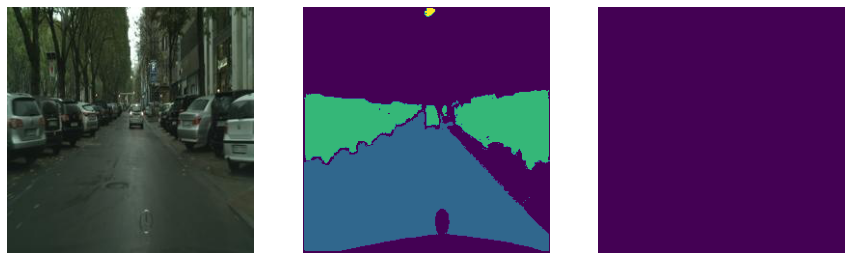

In [27]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

#@tf.function
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, label in dataset.take(num):
      pred_mask, _, _ = model.predict(image)
      display([image[0], label[0], create_mask(pred_mask)])
  else:
    pred_out, _, _ = model.predict(sample_image)
    display([sample_image[0], sample_label[0], create_mask(pred_out)])
    
show_predictions()

Epoch 1/200
13/12 [===============================] - ETA: 0s - loss: 2.4915 - n22_conv1_1x1_loss: 1.4025 - aux_22_loss: 1.9470 - aux_12_loss: 1.9385 - n22_conv1_1x1_accuracy: 0.3767 - aux_22_accuracy: 0.2233 - aux_12_accuracy: 0.2489

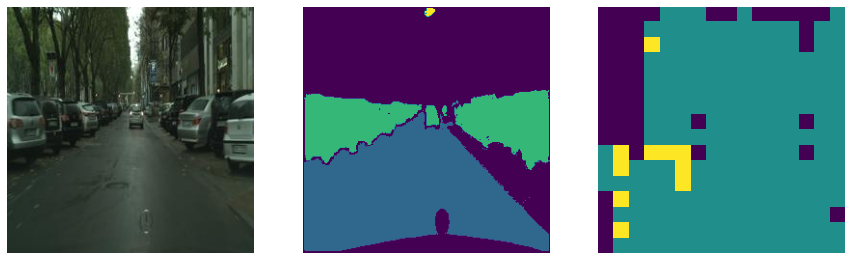


Sample Prediction after epoch 1

13/12 [===============================] - 15s 1s/step - loss: 2.4915 - n22_conv1_1x1_loss: 1.4025 - aux_22_loss: 1.9470 - aux_12_loss: 1.9385 - n22_conv1_1x1_accuracy: 0.3767 - aux_22_accuracy: 0.2233 - aux_12_accuracy: 0.2489 - val_loss: 15.9033 - val_n22_conv1_1x1_loss: 8.8578 - val_aux_22_loss: 14.9305 - val_aux_12_loss: 6.7085 - val_n22_conv1_1x1_accuracy: 0.4422 - val_aux_22_accuracy: 0.0731 - val_aux_12_accuracy: 0.5678
Epoch 2/200
13/12 [===============================] - ETA: 0s - loss: 1.8320 - n22_conv1_1x1_loss: 0.9753 - aux_22_loss: 1.3903 - aux_12_loss: 1.8782 - n22_conv1_1x1_accuracy: 0.5891 - aux_22_accuracy: 0.4100 - aux_12_accuracy: 0.2567

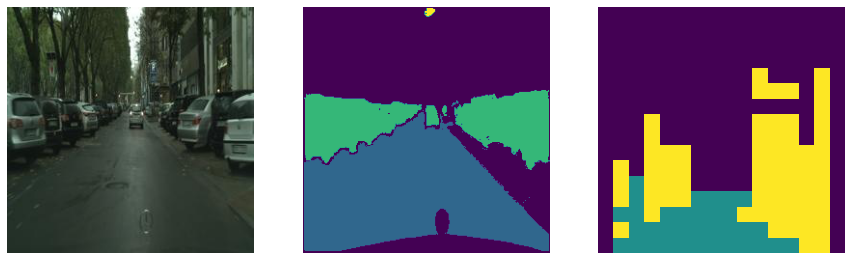


Sample Prediction after epoch 2

13/12 [===============================] - 14s 1s/step - loss: 1.8320 - n22_conv1_1x1_loss: 0.9753 - aux_22_loss: 1.3903 - aux_12_loss: 1.8782 - n22_conv1_1x1_accuracy: 0.5891 - aux_22_accuracy: 0.4100 - aux_12_accuracy: 0.2567 - val_loss: 14.1690 - val_n22_conv1_1x1_loss: 7.0991 - val_aux_22_loss: 14.9915 - val_aux_12_loss: 6.7085 - val_n22_conv1_1x1_accuracy: 0.5458 - val_aux_22_accuracy: 0.0698 - val_aux_12_accuracy: 0.5678
Epoch 3/200
13/12 [===============================] - ETA: 0s - loss: 1.3966 - n22_conv1_1x1_loss: 0.7306 - aux_22_loss: 1.0084 - aux_12_loss: 1.6418 - n22_conv1_1x1_accuracy: 0.7129 - aux_22_accuracy: 0.6047 - aux_12_accuracy: 0.3198

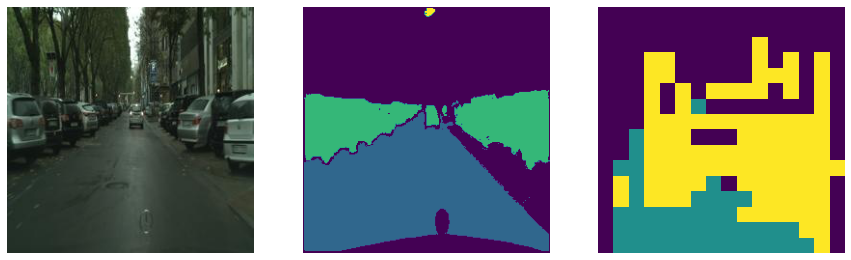


Sample Prediction after epoch 3

13/12 [===============================] - 14s 1s/step - loss: 1.3966 - n22_conv1_1x1_loss: 0.7306 - aux_22_loss: 1.0084 - aux_12_loss: 1.6418 - n22_conv1_1x1_accuracy: 0.7129 - aux_22_accuracy: 0.6047 - aux_12_accuracy: 0.3198 - val_loss: 15.1146 - val_n22_conv1_1x1_loss: 7.8488 - val_aux_22_loss: 13.0405 - val_aux_12_loss: 12.8095 - val_n22_conv1_1x1_accuracy: 0.5026 - val_aux_22_accuracy: 0.1882 - val_aux_12_accuracy: 0.2009
Epoch 4/200
13/12 [===============================] - ETA: 0s - loss: 1.1858 - n22_conv1_1x1_loss: 0.6247 - aux_22_loss: 0.8234 - aux_12_loss: 1.4489 - n22_conv1_1x1_accuracy: 0.7627 - aux_22_accuracy: 0.7028 - aux_12_accuracy: 0.4102

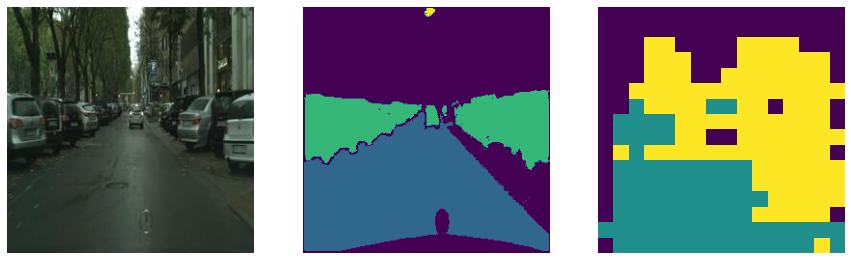


Sample Prediction after epoch 4

13/12 [===============================] - 14s 1s/step - loss: 1.1858 - n22_conv1_1x1_loss: 0.6247 - aux_22_loss: 0.8234 - aux_12_loss: 1.4489 - n22_conv1_1x1_accuracy: 0.7627 - aux_22_accuracy: 0.7028 - aux_12_accuracy: 0.4102 - val_loss: 16.8199 - val_n22_conv1_1x1_loss: 9.8112 - val_aux_22_loss: 11.5109 - val_aux_12_loss: 15.0273 - val_n22_conv1_1x1_accuracy: 0.3852 - val_aux_22_accuracy: 0.2818 - val_aux_12_accuracy: 0.0664
Epoch 5/200
13/12 [===============================] - ETA: 0s - loss: 1.1073 - n22_conv1_1x1_loss: 0.5902 - aux_22_loss: 0.7531 - aux_12_loss: 1.3492 - n22_conv1_1x1_accuracy: 0.7734 - aux_22_accuracy: 0.7251 - aux_12_accuracy: 0.4712

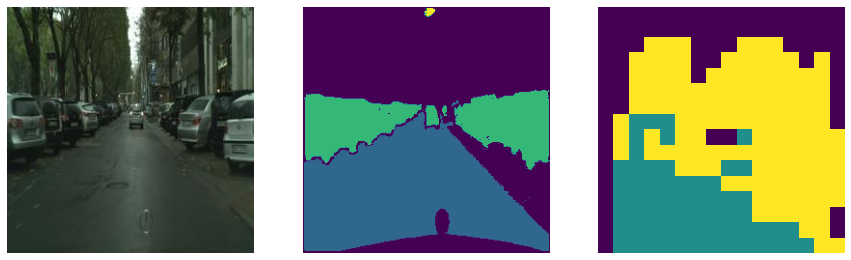


Sample Prediction after epoch 5

13/12 [===============================] - 14s 1s/step - loss: 1.1073 - n22_conv1_1x1_loss: 0.5902 - aux_22_loss: 0.7531 - aux_12_loss: 1.3492 - n22_conv1_1x1_accuracy: 0.7734 - aux_22_accuracy: 0.7251 - aux_12_accuracy: 0.4712 - val_loss: 16.7810 - val_n22_conv1_1x1_loss: 9.7401 - val_aux_22_loss: 11.6046 - val_aux_12_loss: 14.9942 - val_n22_conv1_1x1_accuracy: 0.3895 - val_aux_22_accuracy: 0.2765 - val_aux_12_accuracy: 0.0685
Epoch 6/200
13/12 [===============================] - ETA: 0s - loss: 0.9839 - n22_conv1_1x1_loss: 0.5283 - aux_22_loss: 0.6536 - aux_12_loss: 1.2134 - n22_conv1_1x1_accuracy: 0.7864 - aux_22_accuracy: 0.7521 - aux_12_accuracy: 0.5458

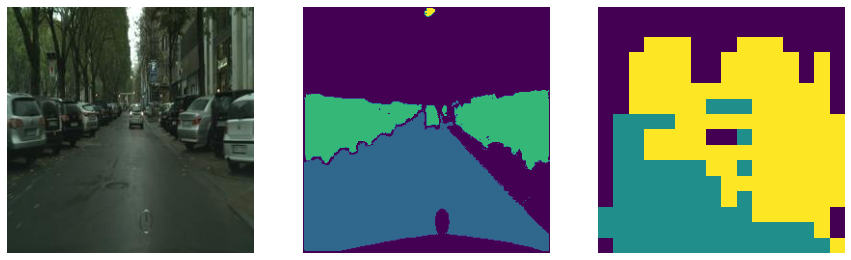


Sample Prediction after epoch 6

13/12 [===============================] - 14s 1s/step - loss: 0.9839 - n22_conv1_1x1_loss: 0.5283 - aux_22_loss: 0.6536 - aux_12_loss: 1.2134 - n22_conv1_1x1_accuracy: 0.7864 - aux_22_accuracy: 0.7521 - aux_12_accuracy: 0.5458 - val_loss: 16.4413 - val_n22_conv1_1x1_loss: 9.1489 - val_aux_22_loss: 12.2333 - val_aux_12_loss: 14.9942 - val_n22_conv1_1x1_accuracy: 0.4243 - val_aux_22_accuracy: 0.2333 - val_aux_12_accuracy: 0.0685
Epoch 7/200
13/12 [===============================] - ETA: 0s - loss: 0.9249 - n22_conv1_1x1_loss: 0.5029 - aux_22_loss: 0.6070 - aux_12_loss: 1.1201 - n22_conv1_1x1_accuracy: 0.7962 - aux_22_accuracy: 0.7658 - aux_12_accuracy: 0.6041

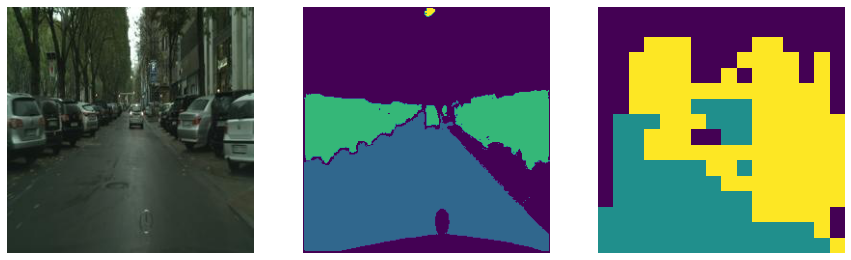


Sample Prediction after epoch 7

13/12 [===============================] - 14s 1s/step - loss: 0.9249 - n22_conv1_1x1_loss: 0.5029 - aux_22_loss: 0.6070 - aux_12_loss: 1.1201 - n22_conv1_1x1_accuracy: 0.7962 - aux_22_accuracy: 0.7658 - aux_12_accuracy: 0.6041 - val_loss: 16.1561 - val_n22_conv1_1x1_loss: 8.8593 - val_aux_22_loss: 12.2445 - val_aux_12_loss: 14.9942 - val_n22_conv1_1x1_accuracy: 0.4367 - val_aux_22_accuracy: 0.2383 - val_aux_12_accuracy: 0.0685
Epoch 8/200
13/12 [===============================] - ETA: 0s - loss: 0.8539 - n22_conv1_1x1_loss: 0.4592 - aux_22_loss: 0.5589 - aux_12_loss: 1.0699 - n22_conv1_1x1_accuracy: 0.8119 - aux_22_accuracy: 0.7811 - aux_12_accuracy: 0.6266

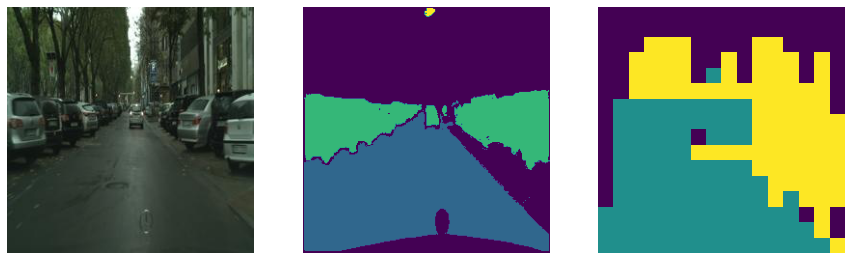


Sample Prediction after epoch 8

13/12 [===============================] - 14s 1s/step - loss: 0.8539 - n22_conv1_1x1_loss: 0.4592 - aux_22_loss: 0.5589 - aux_12_loss: 1.0699 - n22_conv1_1x1_accuracy: 0.8119 - aux_22_accuracy: 0.7811 - aux_12_accuracy: 0.6266 - val_loss: 15.7407 - val_n22_conv1_1x1_loss: 8.3981 - val_aux_22_loss: 12.3587 - val_aux_12_loss: 14.9942 - val_n22_conv1_1x1_accuracy: 0.4611 - val_aux_22_accuracy: 0.2186 - val_aux_12_accuracy: 0.0685
Epoch 9/200
13/12 [===============================] - ETA: 0s - loss: 0.8159 - n22_conv1_1x1_loss: 0.4390 - aux_22_loss: 0.5328 - aux_12_loss: 1.0232 - n22_conv1_1x1_accuracy: 0.8186 - aux_22_accuracy: 0.7914 - aux_12_accuracy: 0.6548

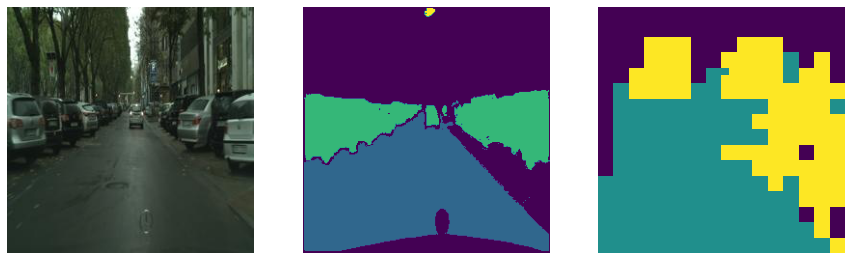


Sample Prediction after epoch 9

13/12 [===============================] - 14s 1s/step - loss: 0.8159 - n22_conv1_1x1_loss: 0.4390 - aux_22_loss: 0.5328 - aux_12_loss: 1.0232 - n22_conv1_1x1_accuracy: 0.8186 - aux_22_accuracy: 0.7914 - aux_12_accuracy: 0.6548 - val_loss: 15.7272 - val_n22_conv1_1x1_loss: 8.3322 - val_aux_22_loss: 12.4899 - val_aux_12_loss: 14.9942 - val_n22_conv1_1x1_accuracy: 0.4650 - val_aux_22_accuracy: 0.2143 - val_aux_12_accuracy: 0.0685
Epoch 10/200
13/12 [===============================] - ETA: 0s - loss: 0.8020 - n22_conv1_1x1_loss: 0.4336 - aux_22_loss: 0.5232 - aux_12_loss: 0.9946 - n22_conv1_1x1_accuracy: 0.8222 - aux_22_accuracy: 0.7967 - aux_12_accuracy: 0.6703

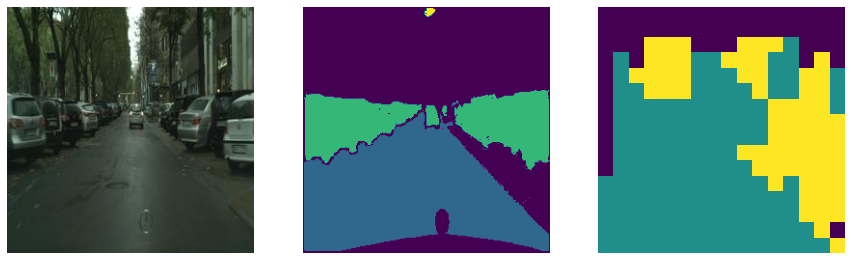


Sample Prediction after epoch 10

13/12 [===============================] - 14s 1s/step - loss: 0.8020 - n22_conv1_1x1_loss: 0.4336 - aux_22_loss: 0.5232 - aux_12_loss: 0.9946 - n22_conv1_1x1_accuracy: 0.8222 - aux_22_accuracy: 0.7967 - aux_12_accuracy: 0.6703 - val_loss: 15.8752 - val_n22_conv1_1x1_loss: 8.4294 - val_aux_22_loss: 12.6166 - val_aux_12_loss: 14.9942 - val_n22_conv1_1x1_accuracy: 0.4550 - val_aux_22_accuracy: 0.2089 - val_aux_12_accuracy: 0.0685
Epoch 11/200
13/12 [===============================] - ETA: 0s - loss: 0.7488 - n22_conv1_1x1_loss: 0.4033 - aux_22_loss: 0.4857 - aux_12_loss: 0.9448 - n22_conv1_1x1_accuracy: 0.8290 - aux_22_accuracy: 0.8020 - aux_12_accuracy: 0.6745

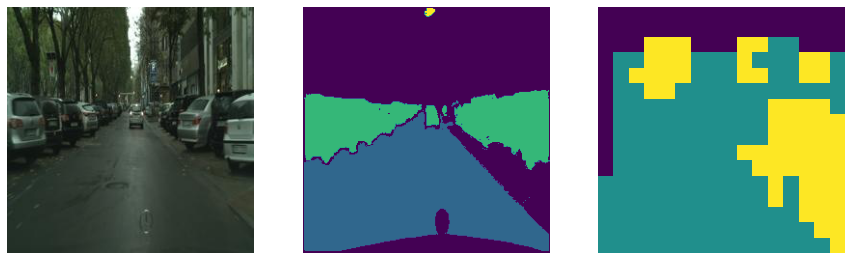


Sample Prediction after epoch 11

13/12 [===============================] - 14s 1s/step - loss: 0.7488 - n22_conv1_1x1_loss: 0.4033 - aux_22_loss: 0.4857 - aux_12_loss: 0.9448 - n22_conv1_1x1_accuracy: 0.8290 - aux_22_accuracy: 0.8020 - aux_12_accuracy: 0.6745 - val_loss: 16.4120 - val_n22_conv1_1x1_loss: 8.9842 - val_aux_22_loss: 12.5721 - val_aux_12_loss: 14.9934 - val_n22_conv1_1x1_accuracy: 0.4250 - val_aux_22_accuracy: 0.2064 - val_aux_12_accuracy: 0.0685
Epoch 12/200
13/12 [===============================] - ETA: 0s - loss: 0.7177 - n22_conv1_1x1_loss: 0.3848 - aux_22_loss: 0.4728 - aux_12_loss: 0.8983 - n22_conv1_1x1_accuracy: 0.8399 - aux_22_accuracy: 0.8117 - aux_12_accuracy: 0.7028

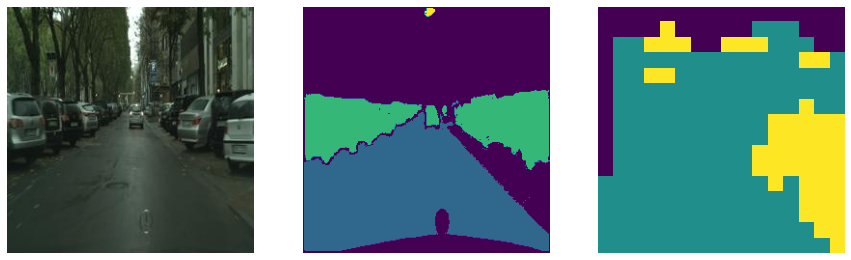


Sample Prediction after epoch 12

13/12 [===============================] - 14s 1s/step - loss: 0.7177 - n22_conv1_1x1_loss: 0.3848 - aux_22_loss: 0.4728 - aux_12_loss: 0.8983 - n22_conv1_1x1_accuracy: 0.8399 - aux_22_accuracy: 0.8117 - aux_12_accuracy: 0.7028 - val_loss: 16.7386 - val_n22_conv1_1x1_loss: 9.1077 - val_aux_22_loss: 13.0794 - val_aux_12_loss: 14.9942 - val_n22_conv1_1x1_accuracy: 0.4076 - val_aux_22_accuracy: 0.1603 - val_aux_12_accuracy: 0.0685
Epoch 13/200
13/12 [===============================] - ETA: 0s - loss: 0.6755 - n22_conv1_1x1_loss: 0.3615 - aux_22_loss: 0.4347 - aux_12_loss: 0.8755 - n22_conv1_1x1_accuracy: 0.8480 - aux_22_accuracy: 0.8224 - aux_12_accuracy: 0.7134

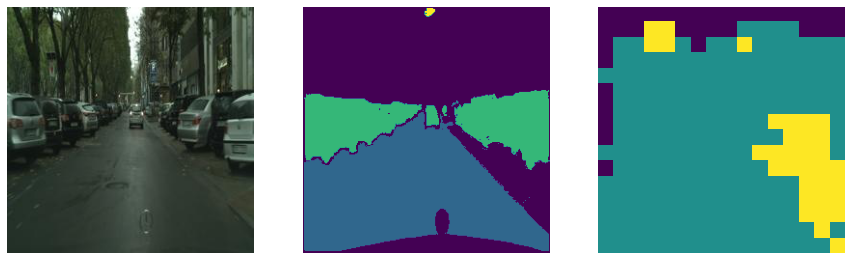


Sample Prediction after epoch 13

13/12 [===============================] - 14s 1s/step - loss: 0.6755 - n22_conv1_1x1_loss: 0.3615 - aux_22_loss: 0.4347 - aux_12_loss: 0.8755 - n22_conv1_1x1_accuracy: 0.8480 - aux_22_accuracy: 0.8224 - aux_12_accuracy: 0.7134 - val_loss: 16.7624 - val_n22_conv1_1x1_loss: 9.0846 - val_aux_22_loss: 13.1969 - val_aux_12_loss: 14.9942 - val_n22_conv1_1x1_accuracy: 0.4043 - val_aux_22_accuracy: 0.1492 - val_aux_12_accuracy: 0.0685
Epoch 14/200
13/12 [===============================] - ETA: 0s - loss: 0.6501 - n22_conv1_1x1_loss: 0.3467 - aux_22_loss: 0.4248 - aux_12_loss: 0.8340 - n22_conv1_1x1_accuracy: 0.8555 - aux_22_accuracy: 0.8268 - aux_12_accuracy: 0.7236

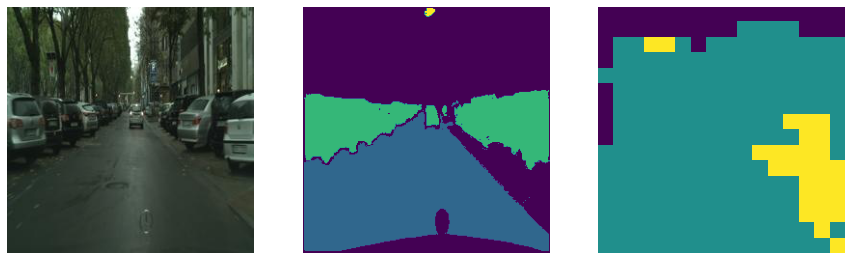


Sample Prediction after epoch 14

13/12 [===============================] - 15s 1s/step - loss: 0.6501 - n22_conv1_1x1_loss: 0.3467 - aux_22_loss: 0.4248 - aux_12_loss: 0.8340 - n22_conv1_1x1_accuracy: 0.8555 - aux_22_accuracy: 0.8268 - aux_12_accuracy: 0.7236 - val_loss: 16.5565 - val_n22_conv1_1x1_loss: 8.9774 - val_aux_22_loss: 12.9501 - val_aux_12_loss: 14.9942 - val_n22_conv1_1x1_accuracy: 0.4000 - val_aux_22_accuracy: 0.1514 - val_aux_12_accuracy: 0.0685
Epoch 15/200
13/12 [===============================] - ETA: 0s - loss: 0.6382 - n22_conv1_1x1_loss: 0.3397 - aux_22_loss: 0.4186 - aux_12_loss: 0.8191 - n22_conv1_1x1_accuracy: 0.8616 - aux_22_accuracy: 0.8351 - aux_12_accuracy: 0.7281

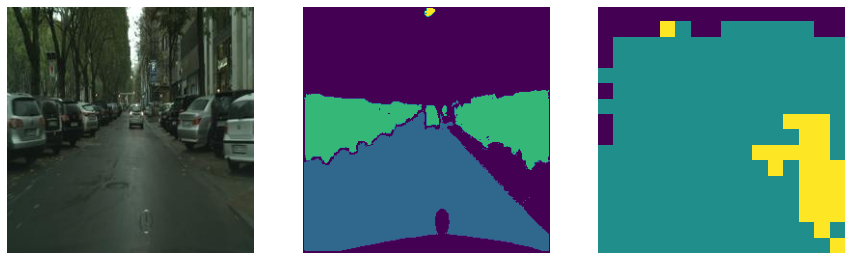


Sample Prediction after epoch 15

13/12 [===============================] - 15s 1s/step - loss: 0.6382 - n22_conv1_1x1_loss: 0.3397 - aux_22_loss: 0.4186 - aux_12_loss: 0.8191 - n22_conv1_1x1_accuracy: 0.8616 - aux_22_accuracy: 0.8351 - aux_12_accuracy: 0.7281 - val_loss: 16.0411 - val_n22_conv1_1x1_loss: 8.7438 - val_aux_22_loss: 12.2537 - val_aux_12_loss: 14.9736 - val_n22_conv1_1x1_accuracy: 0.4010 - val_aux_22_accuracy: 0.1523 - val_aux_12_accuracy: 0.0685
Epoch 16/200
13/12 [===============================] - ETA: 0s - loss: 0.5972 - n22_conv1_1x1_loss: 0.3162 - aux_22_loss: 0.3923 - aux_12_loss: 0.7751 - n22_conv1_1x1_accuracy: 0.8687 - aux_22_accuracy: 0.8422 - aux_12_accuracy: 0.7422

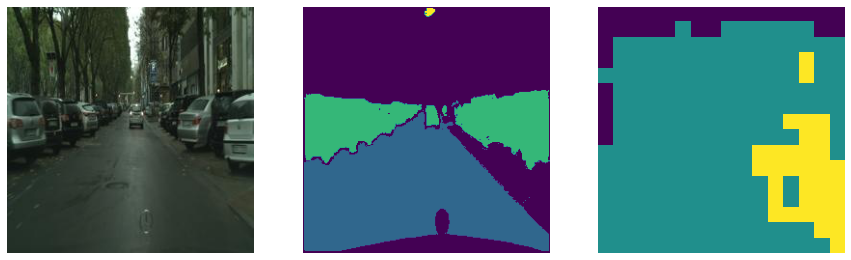


Sample Prediction after epoch 16

13/12 [===============================] - 14s 1s/step - loss: 0.5972 - n22_conv1_1x1_loss: 0.3162 - aux_22_loss: 0.3923 - aux_12_loss: 0.7751 - n22_conv1_1x1_accuracy: 0.8687 - aux_22_accuracy: 0.8422 - aux_12_accuracy: 0.7422 - val_loss: 14.0550 - val_n22_conv1_1x1_loss: 7.2753 - val_aux_22_loss: 11.0152 - val_aux_12_loss: 14.8351 - val_n22_conv1_1x1_accuracy: 0.4100 - val_aux_22_accuracy: 0.1721 - val_aux_12_accuracy: 0.0685
Epoch 17/200
13/12 [===============================] - ETA: 0s - loss: 0.6028 - n22_conv1_1x1_loss: 0.3209 - aux_22_loss: 0.3934 - aux_12_loss: 0.7783 - n22_conv1_1x1_accuracy: 0.8670 - aux_22_accuracy: 0.8409 - aux_12_accuracy: 0.7492

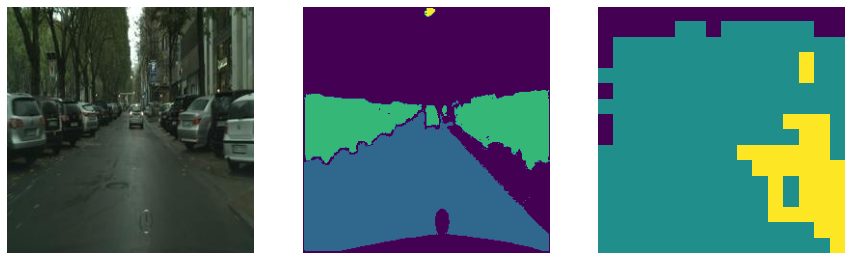


Sample Prediction after epoch 17

13/12 [===============================] - 14s 1s/step - loss: 0.6028 - n22_conv1_1x1_loss: 0.3209 - aux_22_loss: 0.3934 - aux_12_loss: 0.7783 - n22_conv1_1x1_accuracy: 0.8670 - aux_22_accuracy: 0.8409 - aux_12_accuracy: 0.7492 - val_loss: 9.6665 - val_n22_conv1_1x1_loss: 4.4682 - val_aux_22_loss: 7.6555 - val_aux_12_loss: 13.3503 - val_n22_conv1_1x1_accuracy: 0.4028 - val_aux_22_accuracy: 0.2322 - val_aux_12_accuracy: 0.1249
Epoch 18/200
13/12 [===============================] - ETA: 0s - loss: 0.5774 - n22_conv1_1x1_loss: 0.3080 - aux_22_loss: 0.3803 - aux_12_loss: 0.7330 - n22_conv1_1x1_accuracy: 0.8734 - aux_22_accuracy: 0.8482 - aux_12_accuracy: 0.7620

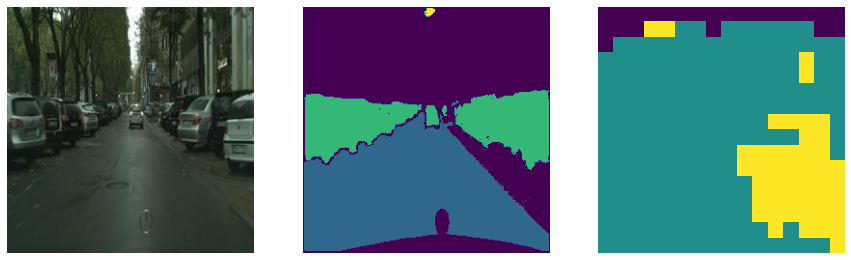


Sample Prediction after epoch 18

13/12 [===============================] - 14s 1s/step - loss: 0.5774 - n22_conv1_1x1_loss: 0.3080 - aux_22_loss: 0.3803 - aux_12_loss: 0.7330 - n22_conv1_1x1_accuracy: 0.8734 - aux_22_accuracy: 0.8482 - aux_12_accuracy: 0.7620 - val_loss: 5.7828 - val_n22_conv1_1x1_loss: 2.3639 - val_aux_22_loss: 4.3956 - val_aux_12_loss: 10.3792 - val_n22_conv1_1x1_accuracy: 0.4414 - val_aux_22_accuracy: 0.3300 - val_aux_12_accuracy: 0.1677
Epoch 19/200
13/12 [===============================] - ETA: 0s - loss: 0.5372 - n22_conv1_1x1_loss: 0.2841 - aux_22_loss: 0.3533 - aux_12_loss: 0.6991 - n22_conv1_1x1_accuracy: 0.8842 - aux_22_accuracy: 0.8602 - aux_12_accuracy: 0.7806

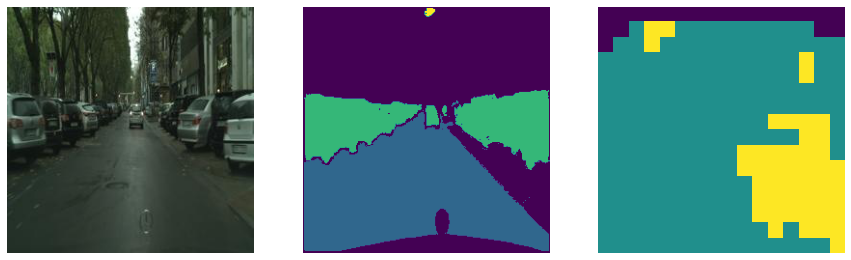


Sample Prediction after epoch 19

13/12 [===============================] - 14s 1s/step - loss: 0.5372 - n22_conv1_1x1_loss: 0.2841 - aux_22_loss: 0.3533 - aux_12_loss: 0.6991 - n22_conv1_1x1_accuracy: 0.8842 - aux_22_accuracy: 0.8602 - aux_12_accuracy: 0.7806 - val_loss: 3.4442 - val_n22_conv1_1x1_loss: 1.4997 - val_aux_22_loss: 2.3597 - val_aux_12_loss: 6.2537 - val_n22_conv1_1x1_accuracy: 0.4826 - val_aux_22_accuracy: 0.4269 - val_aux_12_accuracy: 0.2148
Epoch 20/200
13/12 [===============================] - ETA: 0s - loss: 0.5587 - n22_conv1_1x1_loss: 0.2977 - aux_22_loss: 0.3628 - aux_12_loss: 0.7241 - n22_conv1_1x1_accuracy: 0.8770 - aux_22_accuracy: 0.8533 - aux_12_accuracy: 0.7704

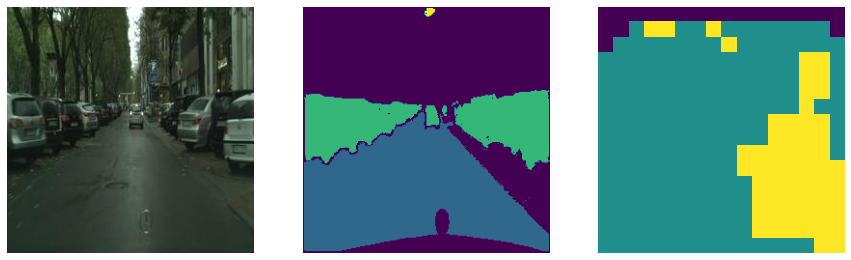


Sample Prediction after epoch 20

13/12 [===============================] - 14s 1s/step - loss: 0.5587 - n22_conv1_1x1_loss: 0.2977 - aux_22_loss: 0.3628 - aux_12_loss: 0.7241 - n22_conv1_1x1_accuracy: 0.8770 - aux_22_accuracy: 0.8533 - aux_12_accuracy: 0.7704 - val_loss: 1.8791 - val_n22_conv1_1x1_loss: 0.9335 - val_aux_22_loss: 1.0502 - val_aux_12_loss: 3.2843 - val_n22_conv1_1x1_accuracy: 0.5831 - val_aux_22_accuracy: 0.5833 - val_aux_12_accuracy: 0.2423
Epoch 21/200
13/12 [===============================] - ETA: 0s - loss: 0.5095 - n22_conv1_1x1_loss: 0.2692 - aux_22_loss: 0.3387 - aux_12_loss: 0.6547 - n22_conv1_1x1_accuracy: 0.8897 - aux_22_accuracy: 0.8640 - aux_12_accuracy: 0.7929

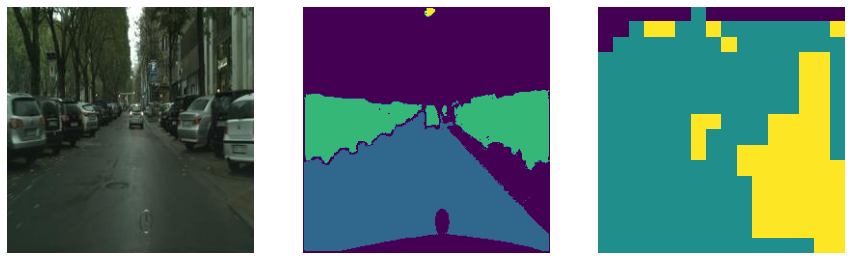


Sample Prediction after epoch 21

13/12 [===============================] - 15s 1s/step - loss: 0.5095 - n22_conv1_1x1_loss: 0.2692 - aux_22_loss: 0.3387 - aux_12_loss: 0.6547 - n22_conv1_1x1_accuracy: 0.8897 - aux_22_accuracy: 0.8640 - aux_12_accuracy: 0.7929 - val_loss: 1.5091 - val_n22_conv1_1x1_loss: 0.8807 - val_aux_22_loss: 0.8213 - val_aux_12_loss: 1.8743 - val_n22_conv1_1x1_accuracy: 0.6627 - val_aux_22_accuracy: 0.7101 - val_aux_12_accuracy: 0.3368
Epoch 22/200
13/12 [===============================] - ETA: 0s - loss: 0.5115 - n22_conv1_1x1_loss: 0.2701 - aux_22_loss: 0.3418 - aux_12_loss: 0.6538 - n22_conv1_1x1_accuracy: 0.8890 - aux_22_accuracy: 0.8628 - aux_12_accuracy: 0.7943

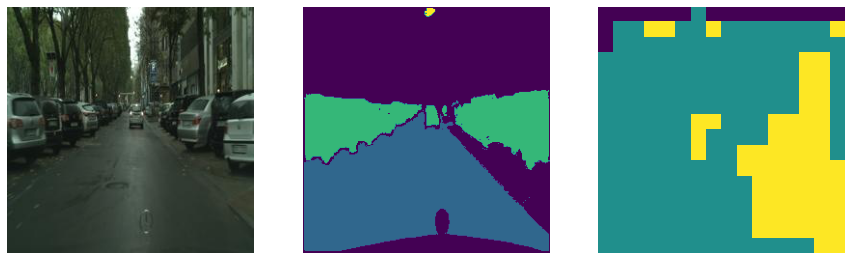


Sample Prediction after epoch 22

13/12 [===============================] - 15s 1s/step - loss: 0.5115 - n22_conv1_1x1_loss: 0.2701 - aux_22_loss: 0.3418 - aux_12_loss: 0.6538 - n22_conv1_1x1_accuracy: 0.8890 - aux_22_accuracy: 0.8628 - aux_12_accuracy: 0.7943 - val_loss: 1.8026 - val_n22_conv1_1x1_loss: 1.1227 - val_aux_22_loss: 1.1491 - val_aux_12_loss: 1.3769 - val_n22_conv1_1x1_accuracy: 0.6065 - val_aux_22_accuracy: 0.6230 - val_aux_12_accuracy: 0.4242
Epoch 23/200
13/12 [===============================] - ETA: 0s - loss: 0.4943 - n22_conv1_1x1_loss: 0.2606 - aux_22_loss: 0.3267 - aux_12_loss: 0.6442 - n22_conv1_1x1_accuracy: 0.8915 - aux_22_accuracy: 0.8676 - aux_12_accuracy: 0.7934

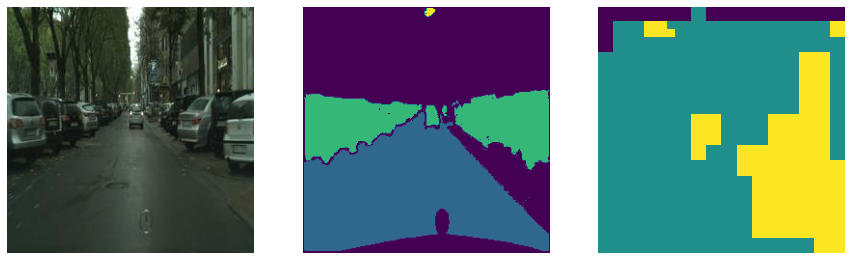


Sample Prediction after epoch 23

13/12 [===============================] - 14s 1s/step - loss: 0.4943 - n22_conv1_1x1_loss: 0.2606 - aux_22_loss: 0.3267 - aux_12_loss: 0.6442 - n22_conv1_1x1_accuracy: 0.8915 - aux_22_accuracy: 0.8676 - aux_12_accuracy: 0.7934 - val_loss: 2.3767 - val_n22_conv1_1x1_loss: 1.5151 - val_aux_22_loss: 1.7197 - val_aux_12_loss: 1.0859 - val_n22_conv1_1x1_accuracy: 0.5704 - val_aux_22_accuracy: 0.5684 - val_aux_12_accuracy: 0.5325
Epoch 24/200
13/12 [===============================] - ETA: 0s - loss: 0.5146 - n22_conv1_1x1_loss: 0.2750 - aux_22_loss: 0.3436 - aux_12_loss: 0.6386 - n22_conv1_1x1_accuracy: 0.8857 - aux_22_accuracy: 0.8625 - aux_12_accuracy: 0.7983

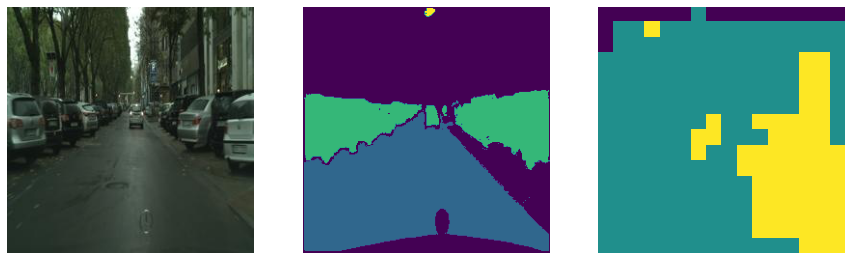


Sample Prediction after epoch 24

13/12 [===============================] - 14s 1s/step - loss: 0.5146 - n22_conv1_1x1_loss: 0.2750 - aux_22_loss: 0.3436 - aux_12_loss: 0.6386 - n22_conv1_1x1_accuracy: 0.8857 - aux_22_accuracy: 0.8625 - aux_12_accuracy: 0.7983 - val_loss: 2.5435 - val_n22_conv1_1x1_loss: 1.6573 - val_aux_22_loss: 1.8240 - val_aux_12_loss: 0.9791 - val_n22_conv1_1x1_accuracy: 0.5704 - val_aux_22_accuracy: 0.5684 - val_aux_12_accuracy: 0.5956
Epoch 25/200
13/12 [===============================] - ETA: 0s - loss: 0.4853 - n22_conv1_1x1_loss: 0.2565 - aux_22_loss: 0.3248 - aux_12_loss: 0.6180 - n22_conv1_1x1_accuracy: 0.8915 - aux_22_accuracy: 0.8687 - aux_12_accuracy: 0.8010

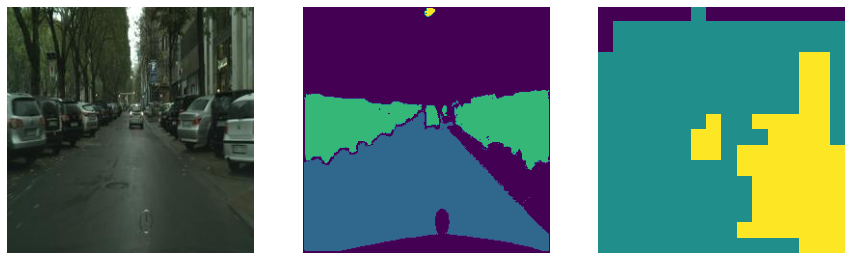


Sample Prediction after epoch 25

13/12 [===============================] - 15s 1s/step - loss: 0.4853 - n22_conv1_1x1_loss: 0.2565 - aux_22_loss: 0.3248 - aux_12_loss: 0.6180 - n22_conv1_1x1_accuracy: 0.8915 - aux_22_accuracy: 0.8687 - aux_12_accuracy: 0.8010 - val_loss: 2.9013 - val_n22_conv1_1x1_loss: 1.9110 - val_aux_22_loss: 2.0961 - val_aux_12_loss: 0.9492 - val_n22_conv1_1x1_accuracy: 0.5704 - val_aux_22_accuracy: 0.5684 - val_aux_12_accuracy: 0.6416
Epoch 26/200
13/12 [===============================] - ETA: 0s - loss: 0.4690 - n22_conv1_1x1_loss: 0.2499 - aux_22_loss: 0.3087 - aux_12_loss: 0.5974 - n22_conv1_1x1_accuracy: 0.8955 - aux_22_accuracy: 0.8734 - aux_12_accuracy: 0.8093

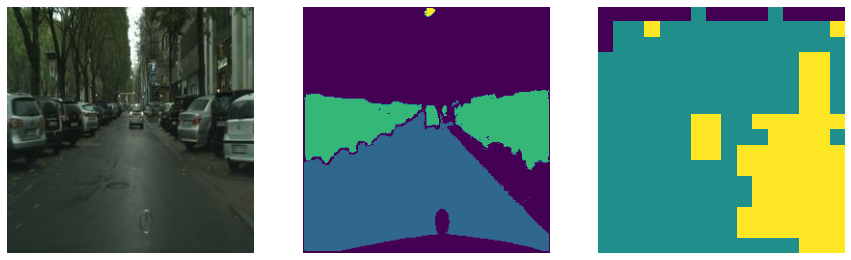


Sample Prediction after epoch 26

13/12 [===============================] - 14s 1s/step - loss: 0.4690 - n22_conv1_1x1_loss: 0.2499 - aux_22_loss: 0.3087 - aux_12_loss: 0.5974 - n22_conv1_1x1_accuracy: 0.8955 - aux_22_accuracy: 0.8734 - aux_12_accuracy: 0.8093 - val_loss: 2.6772 - val_n22_conv1_1x1_loss: 1.7214 - val_aux_22_loss: 1.9766 - val_aux_12_loss: 1.0322 - val_n22_conv1_1x1_accuracy: 0.5704 - val_aux_22_accuracy: 0.5684 - val_aux_12_accuracy: 0.6411
Epoch 27/200
13/12 [===============================] - ETA: 0s - loss: 0.4753 - n22_conv1_1x1_loss: 0.2535 - aux_22_loss: 0.3144 - aux_12_loss: 0.6004 - n22_conv1_1x1_accuracy: 0.8948 - aux_22_accuracy: 0.8738 - aux_12_accuracy: 0.8107

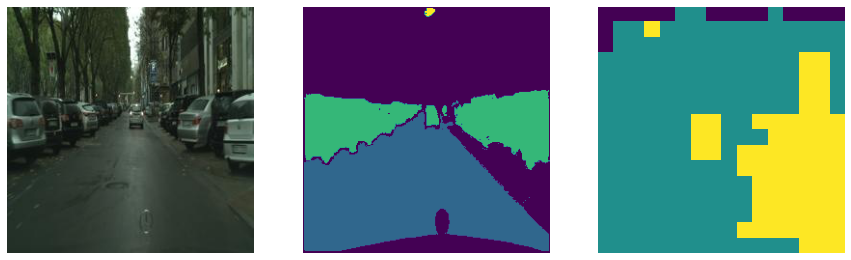


Sample Prediction after epoch 27

13/12 [===============================] - 14s 1s/step - loss: 0.4753 - n22_conv1_1x1_loss: 0.2535 - aux_22_loss: 0.3144 - aux_12_loss: 0.6004 - n22_conv1_1x1_accuracy: 0.8948 - aux_22_accuracy: 0.8738 - aux_12_accuracy: 0.8107 - val_loss: 2.8470 - val_n22_conv1_1x1_loss: 1.8152 - val_aux_22_loss: 2.1387 - val_aux_12_loss: 1.1019 - val_n22_conv1_1x1_accuracy: 0.5704 - val_aux_22_accuracy: 0.5684 - val_aux_12_accuracy: 0.5460
Epoch 28/200
13/12 [===============================] - ETA: 0s - loss: 0.4580 - n22_conv1_1x1_loss: 0.2414 - aux_22_loss: 0.3069 - aux_12_loss: 0.5860 - n22_conv1_1x1_accuracy: 0.8986 - aux_22_accuracy: 0.8742 - aux_12_accuracy: 0.8143

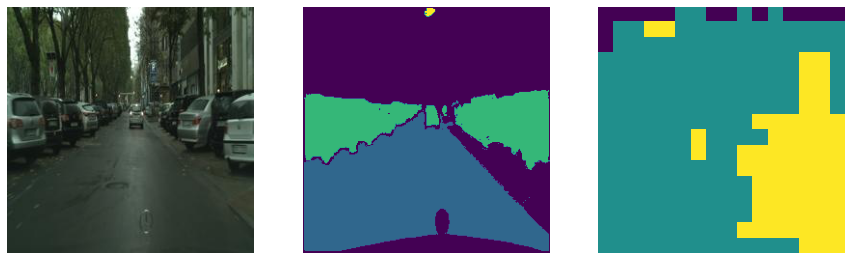


Sample Prediction after epoch 28

13/12 [===============================] - 14s 1s/step - loss: 0.4580 - n22_conv1_1x1_loss: 0.2414 - aux_22_loss: 0.3069 - aux_12_loss: 0.5860 - n22_conv1_1x1_accuracy: 0.8986 - aux_22_accuracy: 0.8742 - aux_12_accuracy: 0.8143 - val_loss: 3.1257 - val_n22_conv1_1x1_loss: 2.0208 - val_aux_22_loss: 2.3352 - val_aux_12_loss: 1.0676 - val_n22_conv1_1x1_accuracy: 0.5704 - val_aux_22_accuracy: 0.5684 - val_aux_12_accuracy: 0.5885
Epoch 29/200
13/12 [===============================] - ETA: 0s - loss: 0.4483 - n22_conv1_1x1_loss: 0.2375 - aux_22_loss: 0.3008 - aux_12_loss: 0.5655 - n22_conv1_1x1_accuracy: 0.8992 - aux_22_accuracy: 0.8770 - aux_12_accuracy: 0.8202

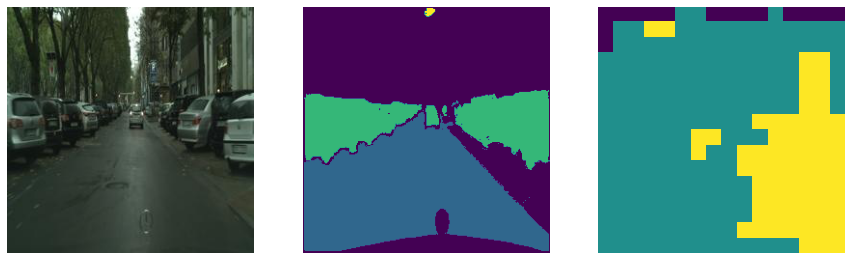


Sample Prediction after epoch 29

13/12 [===============================] - 14s 1s/step - loss: 0.4483 - n22_conv1_1x1_loss: 0.2375 - aux_22_loss: 0.3008 - aux_12_loss: 0.5655 - n22_conv1_1x1_accuracy: 0.8992 - aux_22_accuracy: 0.8770 - aux_12_accuracy: 0.8202 - val_loss: 3.3289 - val_n22_conv1_1x1_loss: 2.1470 - val_aux_22_loss: 2.5583 - val_aux_12_loss: 0.9909 - val_n22_conv1_1x1_accuracy: 0.5704 - val_aux_22_accuracy: 0.5684 - val_aux_12_accuracy: 0.6118
Epoch 30/200
13/12 [===============================] - ETA: 0s - loss: 0.4386 - n22_conv1_1x1_loss: 0.2325 - aux_22_loss: 0.2949 - aux_12_loss: 0.5506 - n22_conv1_1x1_accuracy: 0.9032 - aux_22_accuracy: 0.8816 - aux_12_accuracy: 0.8241

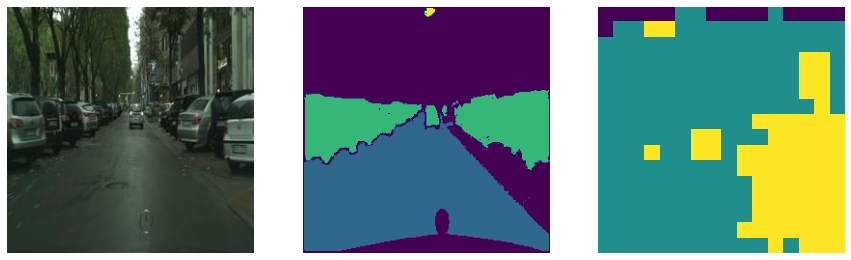


Sample Prediction after epoch 30

13/12 [===============================] - 14s 1s/step - loss: 0.4386 - n22_conv1_1x1_loss: 0.2325 - aux_22_loss: 0.2949 - aux_12_loss: 0.5506 - n22_conv1_1x1_accuracy: 0.9032 - aux_22_accuracy: 0.8816 - aux_12_accuracy: 0.8241 - val_loss: 3.3144 - val_n22_conv1_1x1_loss: 2.1064 - val_aux_22_loss: 2.6309 - val_aux_12_loss: 0.9731 - val_n22_conv1_1x1_accuracy: 0.5704 - val_aux_22_accuracy: 0.5684 - val_aux_12_accuracy: 0.6021
Epoch 31/200
13/12 [===============================] - ETA: 0s - loss: 0.4350 - n22_conv1_1x1_loss: 0.2297 - aux_22_loss: 0.2901 - aux_12_loss: 0.5579 - n22_conv1_1x1_accuracy: 0.9022 - aux_22_accuracy: 0.8820 - aux_12_accuracy: 0.8187

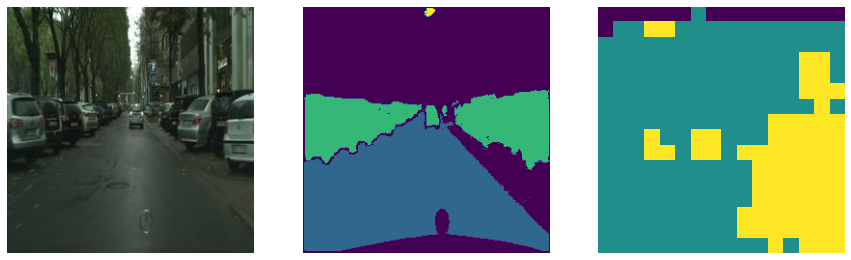


Sample Prediction after epoch 31

13/12 [===============================] - 14s 1s/step - loss: 0.4350 - n22_conv1_1x1_loss: 0.2297 - aux_22_loss: 0.2901 - aux_12_loss: 0.5579 - n22_conv1_1x1_accuracy: 0.9022 - aux_22_accuracy: 0.8820 - aux_12_accuracy: 0.8187 - val_loss: 3.1819 - val_n22_conv1_1x1_loss: 2.0311 - val_aux_22_loss: 2.4868 - val_aux_12_loss: 0.9754 - val_n22_conv1_1x1_accuracy: 0.5704 - val_aux_22_accuracy: 0.5684 - val_aux_12_accuracy: 0.6310
Epoch 32/200
13/12 [===============================] - ETA: 0s - loss: 0.4355 - n22_conv1_1x1_loss: 0.2319 - aux_22_loss: 0.2971 - aux_12_loss: 0.5296 - n22_conv1_1x1_accuracy: 0.9020 - aux_22_accuracy: 0.8783 - aux_12_accuracy: 0.8271

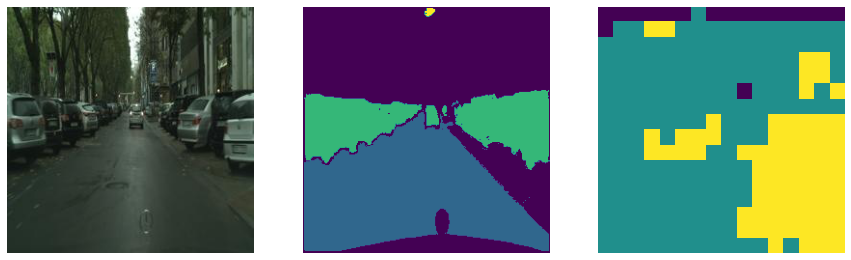


Sample Prediction after epoch 32

13/12 [===============================] - 15s 1s/step - loss: 0.4355 - n22_conv1_1x1_loss: 0.2319 - aux_22_loss: 0.2971 - aux_12_loss: 0.5296 - n22_conv1_1x1_accuracy: 0.9020 - aux_22_accuracy: 0.8783 - aux_12_accuracy: 0.8271 - val_loss: 3.2028 - val_n22_conv1_1x1_loss: 2.1212 - val_aux_22_loss: 2.3390 - val_aux_12_loss: 0.9126 - val_n22_conv1_1x1_accuracy: 0.5704 - val_aux_22_accuracy: 0.5684 - val_aux_12_accuracy: 0.6648
Epoch 33/200
13/12 [===============================] - ETA: 0s - loss: 0.4167 - n22_conv1_1x1_loss: 0.2198 - aux_22_loss: 0.2806 - aux_12_loss: 0.5291 - n22_conv1_1x1_accuracy: 0.9059 - aux_22_accuracy: 0.8852 - aux_12_accuracy: 0.8280

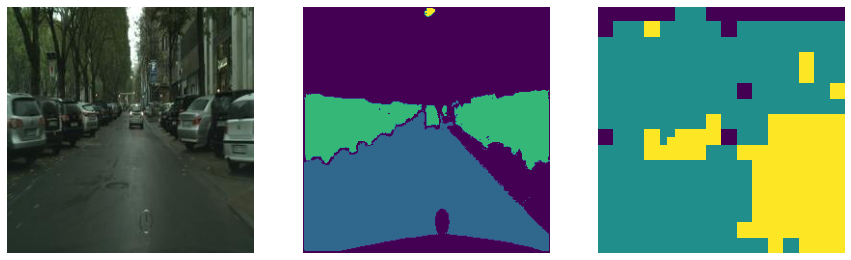


Sample Prediction after epoch 33

13/12 [===============================] - 14s 1s/step - loss: 0.4167 - n22_conv1_1x1_loss: 0.2198 - aux_22_loss: 0.2806 - aux_12_loss: 0.5291 - n22_conv1_1x1_accuracy: 0.9059 - aux_22_accuracy: 0.8852 - aux_12_accuracy: 0.8280 - val_loss: 3.3928 - val_n22_conv1_1x1_loss: 2.2604 - val_aux_22_loss: 2.4347 - val_aux_12_loss: 0.9905 - val_n22_conv1_1x1_accuracy: 0.5704 - val_aux_22_accuracy: 0.5684 - val_aux_12_accuracy: 0.5829
Epoch 34/200
13/12 [===============================] - ETA: 0s - loss: 0.4170 - n22_conv1_1x1_loss: 0.2221 - aux_22_loss: 0.2822 - aux_12_loss: 0.5129 - n22_conv1_1x1_accuracy: 0.9053 - aux_22_accuracy: 0.8826 - aux_12_accuracy: 0.8328

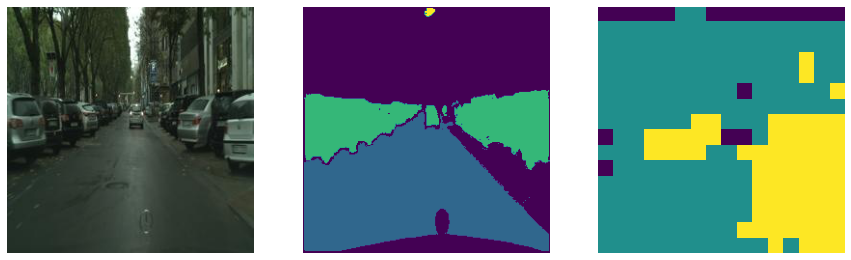


Sample Prediction after epoch 34

13/12 [===============================] - 14s 1s/step - loss: 0.4170 - n22_conv1_1x1_loss: 0.2221 - aux_22_loss: 0.2822 - aux_12_loss: 0.5129 - n22_conv1_1x1_accuracy: 0.9053 - aux_22_accuracy: 0.8826 - aux_12_accuracy: 0.8328 - val_loss: 3.2192 - val_n22_conv1_1x1_loss: 2.1250 - val_aux_22_loss: 2.2950 - val_aux_12_loss: 1.1016 - val_n22_conv1_1x1_accuracy: 0.5704 - val_aux_22_accuracy: 0.5684 - val_aux_12_accuracy: 0.5801
Epoch 35/200
13/12 [===============================] - ETA: 0s - loss: 0.4132 - n22_conv1_1x1_loss: 0.2200 - aux_22_loss: 0.2783 - aux_12_loss: 0.5114 - n22_conv1_1x1_accuracy: 0.9054 - aux_22_accuracy: 0.8841 - aux_12_accuracy: 0.8355

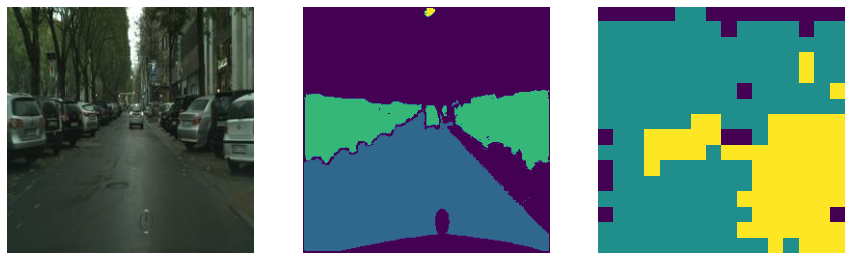


Sample Prediction after epoch 35

13/12 [===============================] - 14s 1s/step - loss: 0.4132 - n22_conv1_1x1_loss: 0.2200 - aux_22_loss: 0.2783 - aux_12_loss: 0.5114 - n22_conv1_1x1_accuracy: 0.9054 - aux_22_accuracy: 0.8841 - aux_12_accuracy: 0.8355 - val_loss: 3.1277 - val_n22_conv1_1x1_loss: 2.0715 - val_aux_22_loss: 2.2227 - val_aux_12_loss: 1.0451 - val_n22_conv1_1x1_accuracy: 0.5704 - val_aux_22_accuracy: 0.5684 - val_aux_12_accuracy: 0.6235
Epoch 36/200
13/12 [===============================] - ETA: 0s - loss: 0.4114 - n22_conv1_1x1_loss: 0.2178 - aux_22_loss: 0.2800 - aux_12_loss: 0.5099 - n22_conv1_1x1_accuracy: 0.9068 - aux_22_accuracy: 0.8830 - aux_12_accuracy: 0.8357

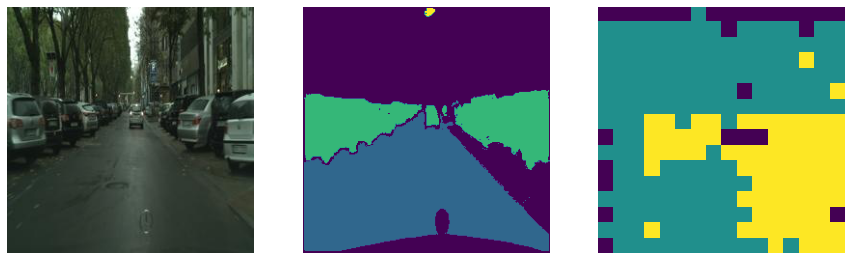


Sample Prediction after epoch 36

13/12 [===============================] - 15s 1s/step - loss: 0.4114 - n22_conv1_1x1_loss: 0.2178 - aux_22_loss: 0.2800 - aux_12_loss: 0.5099 - n22_conv1_1x1_accuracy: 0.9068 - aux_22_accuracy: 0.8830 - aux_12_accuracy: 0.8357 - val_loss: 3.3188 - val_n22_conv1_1x1_loss: 2.2205 - val_aux_22_loss: 2.2967 - val_aux_12_loss: 1.1224 - val_n22_conv1_1x1_accuracy: 0.5704 - val_aux_22_accuracy: 0.5683 - val_aux_12_accuracy: 0.5664
Epoch 37/200
13/12 [===============================] - ETA: 0s - loss: 0.4061 - n22_conv1_1x1_loss: 0.2161 - aux_22_loss: 0.2765 - aux_12_loss: 0.4966 - n22_conv1_1x1_accuracy: 0.9074 - aux_22_accuracy: 0.8841 - aux_12_accuracy: 0.8399

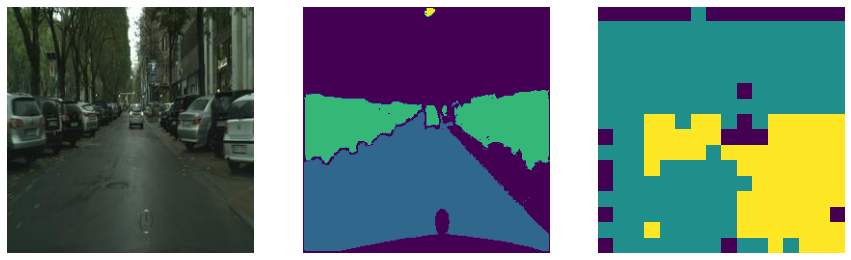


Sample Prediction after epoch 37

13/12 [===============================] - 14s 1s/step - loss: 0.4061 - n22_conv1_1x1_loss: 0.2161 - aux_22_loss: 0.2765 - aux_12_loss: 0.4966 - n22_conv1_1x1_accuracy: 0.9074 - aux_22_accuracy: 0.8841 - aux_12_accuracy: 0.8399 - val_loss: 3.3134 - val_n22_conv1_1x1_loss: 2.2040 - val_aux_22_loss: 2.3337 - val_aux_12_loss: 1.0997 - val_n22_conv1_1x1_accuracy: 0.5704 - val_aux_22_accuracy: 0.5684 - val_aux_12_accuracy: 0.5729
Epoch 38/200
13/12 [===============================] - ETA: 0s - loss: 0.4020 - n22_conv1_1x1_loss: 0.2136 - aux_22_loss: 0.2730 - aux_12_loss: 0.4950 - n22_conv1_1x1_accuracy: 0.9060 - aux_22_accuracy: 0.8839 - aux_12_accuracy: 0.8373

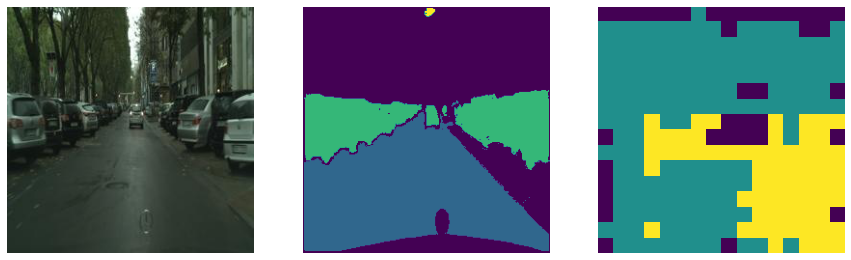


Sample Prediction after epoch 38

13/12 [===============================] - 14s 1s/step - loss: 0.4020 - n22_conv1_1x1_loss: 0.2136 - aux_22_loss: 0.2730 - aux_12_loss: 0.4950 - n22_conv1_1x1_accuracy: 0.9060 - aux_22_accuracy: 0.8839 - aux_12_accuracy: 0.8373 - val_loss: 3.2109 - val_n22_conv1_1x1_loss: 2.1249 - val_aux_22_loss: 2.2749 - val_aux_12_loss: 1.1002 - val_n22_conv1_1x1_accuracy: 0.5704 - val_aux_22_accuracy: 0.5684 - val_aux_12_accuracy: 0.5801
Epoch 39/200
13/12 [===============================] - ETA: 0s - loss: 0.4017 - n22_conv1_1x1_loss: 0.2147 - aux_22_loss: 0.2727 - aux_12_loss: 0.4865 - n22_conv1_1x1_accuracy: 0.9076 - aux_22_accuracy: 0.8867 - aux_12_accuracy: 0.8368

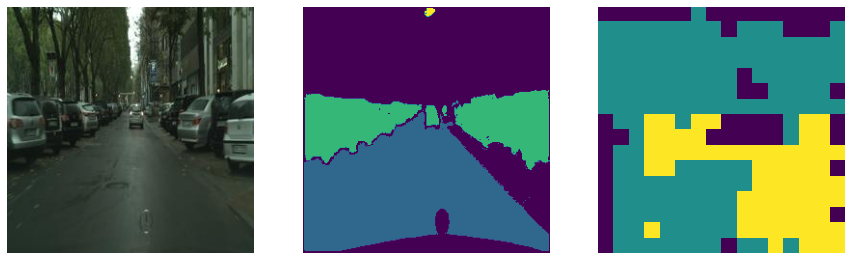


Sample Prediction after epoch 39

13/12 [===============================] - 14s 1s/step - loss: 0.4017 - n22_conv1_1x1_loss: 0.2147 - aux_22_loss: 0.2727 - aux_12_loss: 0.4865 - n22_conv1_1x1_accuracy: 0.9076 - aux_22_accuracy: 0.8867 - aux_12_accuracy: 0.8368 - val_loss: 2.9730 - val_n22_conv1_1x1_loss: 1.8806 - val_aux_22_loss: 2.2745 - val_aux_12_loss: 1.1409 - val_n22_conv1_1x1_accuracy: 0.5704 - val_aux_22_accuracy: 0.5684 - val_aux_12_accuracy: 0.5368
Epoch 40/200
13/12 [===============================] - ETA: 0s - loss: 0.3866 - n22_conv1_1x1_loss: 0.2067 - aux_22_loss: 0.2639 - aux_12_loss: 0.4647 - n22_conv1_1x1_accuracy: 0.9098 - aux_22_accuracy: 0.8882 - aux_12_accuracy: 0.8476

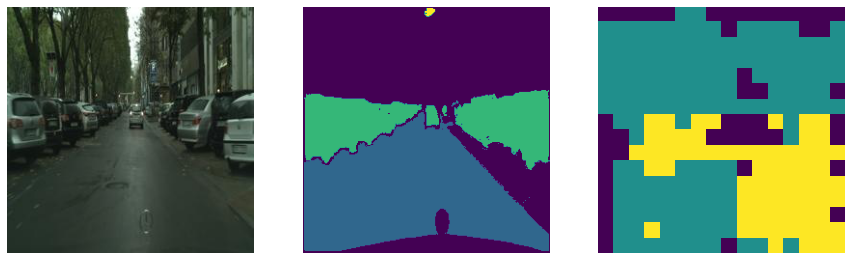


Sample Prediction after epoch 40

13/12 [===============================] - 14s 1s/step - loss: 0.3866 - n22_conv1_1x1_loss: 0.2067 - aux_22_loss: 0.2639 - aux_12_loss: 0.4647 - n22_conv1_1x1_accuracy: 0.9098 - aux_22_accuracy: 0.8882 - aux_12_accuracy: 0.8476 - val_loss: 3.2191 - val_n22_conv1_1x1_loss: 2.1375 - val_aux_22_loss: 2.2545 - val_aux_12_loss: 1.1242 - val_n22_conv1_1x1_accuracy: 0.5704 - val_aux_22_accuracy: 0.5683 - val_aux_12_accuracy: 0.5585
Epoch 41/200
13/12 [===============================] - ETA: 0s - loss: 0.3927 - n22_conv1_1x1_loss: 0.2102 - aux_22_loss: 0.2694 - aux_12_loss: 0.4667 - n22_conv1_1x1_accuracy: 0.9081 - aux_22_accuracy: 0.8857 - aux_12_accuracy: 0.8436

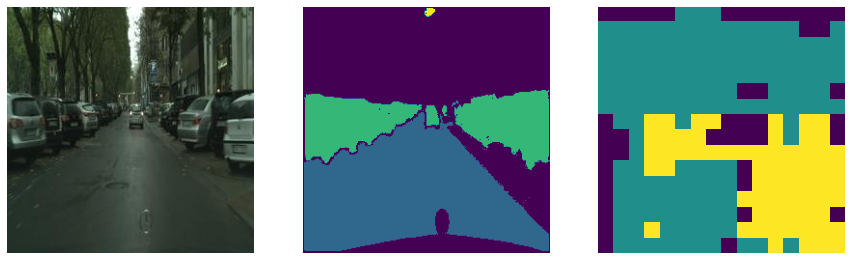


Sample Prediction after epoch 41

13/12 [===============================] - 14s 1s/step - loss: 0.3927 - n22_conv1_1x1_loss: 0.2102 - aux_22_loss: 0.2694 - aux_12_loss: 0.4667 - n22_conv1_1x1_accuracy: 0.9081 - aux_22_accuracy: 0.8857 - aux_12_accuracy: 0.8436 - val_loss: 3.5209 - val_n22_conv1_1x1_loss: 2.4622 - val_aux_22_loss: 2.1688 - val_aux_12_loss: 1.1946 - val_n22_conv1_1x1_accuracy: 0.5704 - val_aux_22_accuracy: 0.5668 - val_aux_12_accuracy: 0.5241
Epoch 42/200
13/12 [===============================] - ETA: 0s - loss: 0.3844 - n22_conv1_1x1_loss: 0.2047 - aux_22_loss: 0.2613 - aux_12_loss: 0.4701 - n22_conv1_1x1_accuracy: 0.9099 - aux_22_accuracy: 0.8878 - aux_12_accuracy: 0.8455

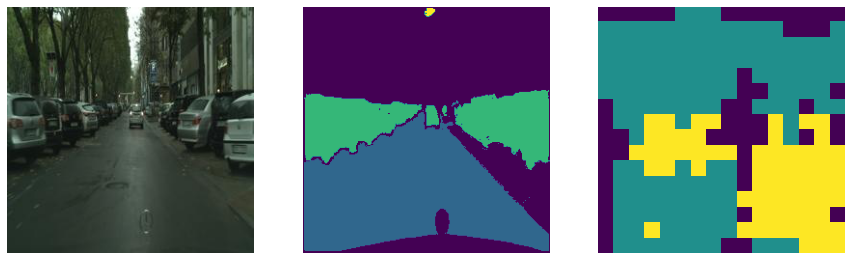


Sample Prediction after epoch 42

13/12 [===============================] - 14s 1s/step - loss: 0.3844 - n22_conv1_1x1_loss: 0.2047 - aux_22_loss: 0.2613 - aux_12_loss: 0.4701 - n22_conv1_1x1_accuracy: 0.9099 - aux_22_accuracy: 0.8878 - aux_12_accuracy: 0.8455 - val_loss: 2.4802 - val_n22_conv1_1x1_loss: 1.4462 - val_aux_22_loss: 2.0549 - val_aux_12_loss: 1.3253 - val_n22_conv1_1x1_accuracy: 0.5392 - val_aux_22_accuracy: 0.5673 - val_aux_12_accuracy: 0.4462
Epoch 43/200
13/12 [===============================] - ETA: 0s - loss: 0.3828 - n22_conv1_1x1_loss: 0.2029 - aux_22_loss: 0.2627 - aux_12_loss: 0.4674 - n22_conv1_1x1_accuracy: 0.9114 - aux_22_accuracy: 0.8887 - aux_12_accuracy: 0.8428

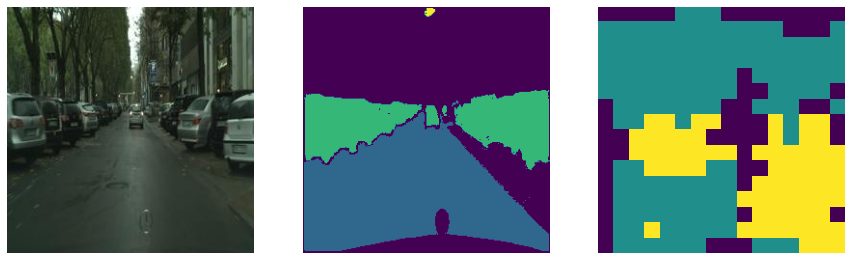


Sample Prediction after epoch 43

13/12 [===============================] - 15s 1s/step - loss: 0.3828 - n22_conv1_1x1_loss: 0.2029 - aux_22_loss: 0.2627 - aux_12_loss: 0.4674 - n22_conv1_1x1_accuracy: 0.9114 - aux_22_accuracy: 0.8887 - aux_12_accuracy: 0.8428 - val_loss: 2.4699 - val_n22_conv1_1x1_loss: 1.4824 - val_aux_22_loss: 1.9723 - val_aux_12_loss: 1.2411 - val_n22_conv1_1x1_accuracy: 0.5527 - val_aux_22_accuracy: 0.5685 - val_aux_12_accuracy: 0.4894
Epoch 44/200
13/12 [===============================] - ETA: 0s - loss: 0.3821 - n22_conv1_1x1_loss: 0.2045 - aux_22_loss: 0.2614 - aux_12_loss: 0.4565 - n22_conv1_1x1_accuracy: 0.9118 - aux_22_accuracy: 0.8902 - aux_12_accuracy: 0.8448

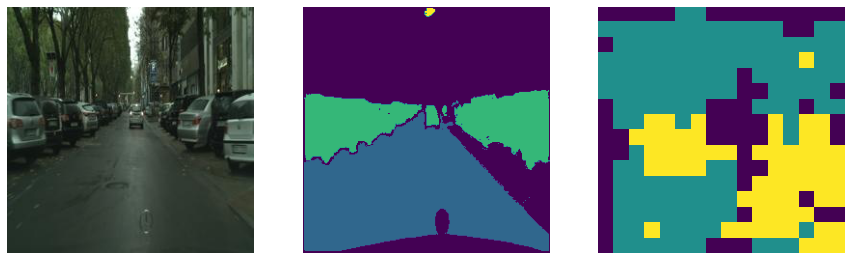


Sample Prediction after epoch 44

13/12 [===============================] - 14s 1s/step - loss: 0.3821 - n22_conv1_1x1_loss: 0.2045 - aux_22_loss: 0.2614 - aux_12_loss: 0.4565 - n22_conv1_1x1_accuracy: 0.9118 - aux_22_accuracy: 0.8902 - aux_12_accuracy: 0.8448 - val_loss: 2.3470 - val_n22_conv1_1x1_loss: 1.4314 - val_aux_22_loss: 1.8332 - val_aux_12_loss: 1.1398 - val_n22_conv1_1x1_accuracy: 0.5668 - val_aux_22_accuracy: 0.5691 - val_aux_12_accuracy: 0.5428
Epoch 45/200
13/12 [===============================] - ETA: 0s - loss: 0.3844 - n22_conv1_1x1_loss: 0.2060 - aux_22_loss: 0.2646 - aux_12_loss: 0.4535 - n22_conv1_1x1_accuracy: 0.9101 - aux_22_accuracy: 0.8884 - aux_12_accuracy: 0.8453

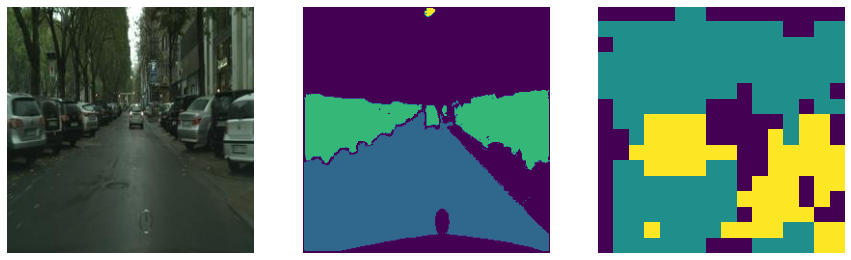


Sample Prediction after epoch 45

13/12 [===============================] - 14s 1s/step - loss: 0.3844 - n22_conv1_1x1_loss: 0.2060 - aux_22_loss: 0.2646 - aux_12_loss: 0.4535 - n22_conv1_1x1_accuracy: 0.9101 - aux_22_accuracy: 0.8884 - aux_12_accuracy: 0.8453 - val_loss: 2.5600 - val_n22_conv1_1x1_loss: 1.6915 - val_aux_22_loss: 1.7333 - val_aux_12_loss: 1.0949 - val_n22_conv1_1x1_accuracy: 0.5716 - val_aux_22_accuracy: 0.5701 - val_aux_12_accuracy: 0.5817
Epoch 46/200
13/12 [===============================] - ETA: 0s - loss: 0.3826 - n22_conv1_1x1_loss: 0.2054 - aux_22_loss: 0.2634 - aux_12_loss: 0.4490 - n22_conv1_1x1_accuracy: 0.9098 - aux_22_accuracy: 0.8866 - aux_12_accuracy: 0.8457

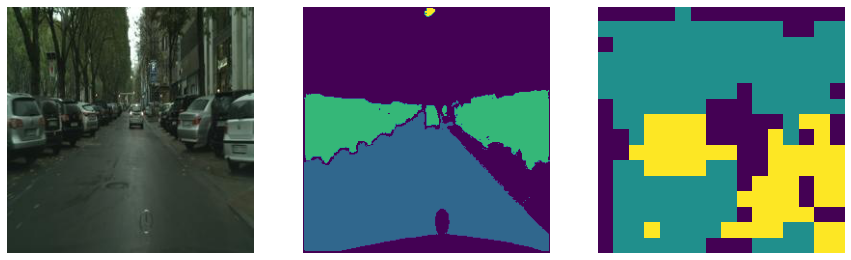


Sample Prediction after epoch 46

13/12 [===============================] - 14s 1s/step - loss: 0.3826 - n22_conv1_1x1_loss: 0.2054 - aux_22_loss: 0.2634 - aux_12_loss: 0.4490 - n22_conv1_1x1_accuracy: 0.9098 - aux_22_accuracy: 0.8866 - aux_12_accuracy: 0.8457 - val_loss: 2.7958 - val_n22_conv1_1x1_loss: 1.9888 - val_aux_22_loss: 1.5947 - val_aux_12_loss: 1.0571 - val_n22_conv1_1x1_accuracy: 0.5704 - val_aux_22_accuracy: 0.5739 - val_aux_12_accuracy: 0.6161
Epoch 47/200
13/12 [===============================] - ETA: 0s - loss: 0.3883 - n22_conv1_1x1_loss: 0.2070 - aux_22_loss: 0.2705 - aux_12_loss: 0.4569 - n22_conv1_1x1_accuracy: 0.9105 - aux_22_accuracy: 0.8866 - aux_12_accuracy: 0.8460

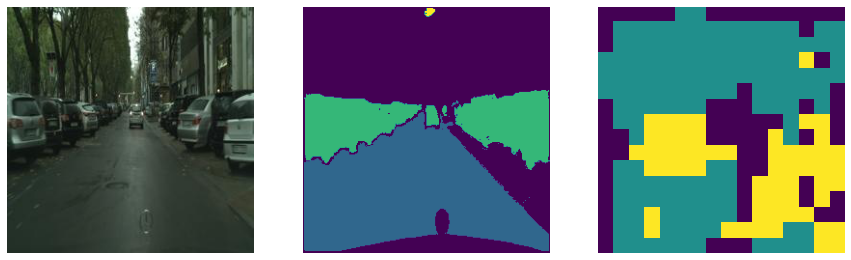


Sample Prediction after epoch 47

13/12 [===============================] - 15s 1s/step - loss: 0.3883 - n22_conv1_1x1_loss: 0.2070 - aux_22_loss: 0.2705 - aux_12_loss: 0.4569 - n22_conv1_1x1_accuracy: 0.9105 - aux_22_accuracy: 0.8866 - aux_12_accuracy: 0.8460 - val_loss: 3.4852 - val_n22_conv1_1x1_loss: 2.7173 - val_aux_22_loss: 1.5016 - val_aux_12_loss: 1.0454 - val_n22_conv1_1x1_accuracy: 0.5704 - val_aux_22_accuracy: 0.5774 - val_aux_12_accuracy: 0.6251
Epoch 48/200
13/12 [===============================] - ETA: 0s - loss: 0.3690 - n22_conv1_1x1_loss: 0.1974 - aux_22_loss: 0.2559 - aux_12_loss: 0.4324 - n22_conv1_1x1_accuracy: 0.9133 - aux_22_accuracy: 0.8926 - aux_12_accuracy: 0.8515

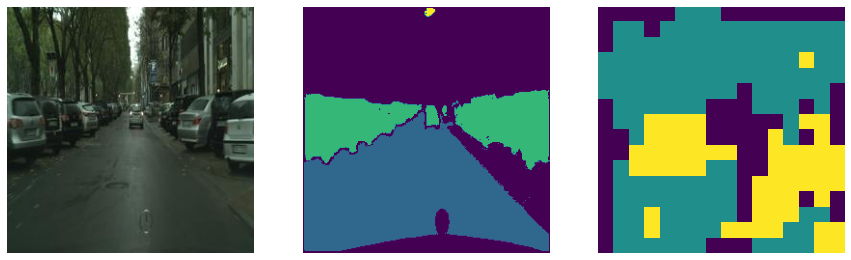


Sample Prediction after epoch 48

13/12 [===============================] - 14s 1s/step - loss: 0.3690 - n22_conv1_1x1_loss: 0.1974 - aux_22_loss: 0.2559 - aux_12_loss: 0.4324 - n22_conv1_1x1_accuracy: 0.9133 - aux_22_accuracy: 0.8926 - aux_12_accuracy: 0.8515 - val_loss: 1.9382 - val_n22_conv1_1x1_loss: 1.2321 - val_aux_22_loss: 1.3557 - val_aux_12_loss: 1.0242 - val_n22_conv1_1x1_accuracy: 0.5852 - val_aux_22_accuracy: 0.5847 - val_aux_12_accuracy: 0.6337
Epoch 49/200
13/12 [===============================] - ETA: 0s - loss: 0.3830 - n22_conv1_1x1_loss: 0.2059 - aux_22_loss: 0.2616 - aux_12_loss: 0.4528 - n22_conv1_1x1_accuracy: 0.9104 - aux_22_accuracy: 0.8886 - aux_12_accuracy: 0.8437

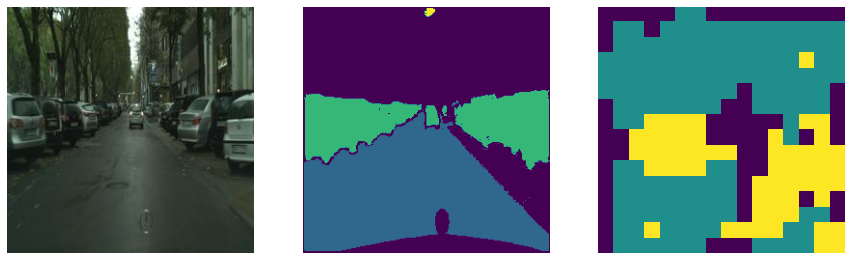


Sample Prediction after epoch 49

13/12 [===============================] - 14s 1s/step - loss: 0.3830 - n22_conv1_1x1_loss: 0.2059 - aux_22_loss: 0.2616 - aux_12_loss: 0.4528 - n22_conv1_1x1_accuracy: 0.9104 - aux_22_accuracy: 0.8886 - aux_12_accuracy: 0.8437 - val_loss: 3.1068 - val_n22_conv1_1x1_loss: 2.4345 - val_aux_22_loss: 1.2798 - val_aux_12_loss: 1.0026 - val_n22_conv1_1x1_accuracy: 0.5732 - val_aux_22_accuracy: 0.5912 - val_aux_12_accuracy: 0.6498
Epoch 50/200
13/12 [===============================] - ETA: 0s - loss: 0.3790 - n22_conv1_1x1_loss: 0.2043 - aux_22_loss: 0.2628 - aux_12_loss: 0.4346 - n22_conv1_1x1_accuracy: 0.9093 - aux_22_accuracy: 0.8881 - aux_12_accuracy: 0.8489

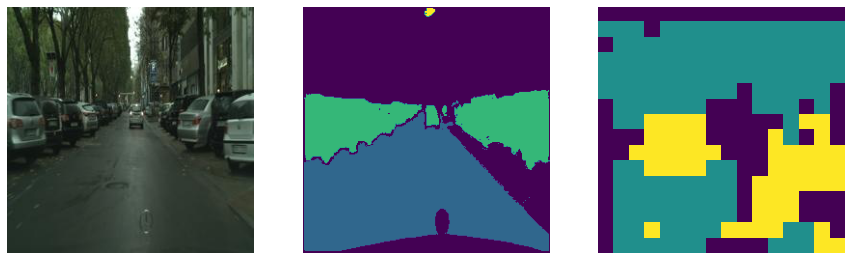


Sample Prediction after epoch 50

13/12 [===============================] - 14s 1s/step - loss: 0.3790 - n22_conv1_1x1_loss: 0.2043 - aux_22_loss: 0.2628 - aux_12_loss: 0.4346 - n22_conv1_1x1_accuracy: 0.9093 - aux_22_accuracy: 0.8881 - aux_12_accuracy: 0.8489 - val_loss: 1.8082 - val_n22_conv1_1x1_loss: 1.1865 - val_aux_22_loss: 1.1551 - val_aux_12_loss: 0.9980 - val_n22_conv1_1x1_accuracy: 0.4981 - val_aux_22_accuracy: 0.6130 - val_aux_12_accuracy: 0.6478
Epoch 51/200
13/12 [===============================] - ETA: 0s - loss: 0.3772 - n22_conv1_1x1_loss: 0.2023 - aux_22_loss: 0.2599 - aux_12_loss: 0.4440 - n22_conv1_1x1_accuracy: 0.9107 - aux_22_accuracy: 0.8882 - aux_12_accuracy: 0.8481

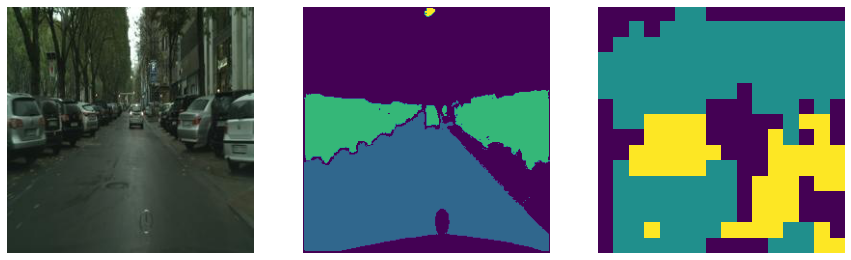


Sample Prediction after epoch 51

13/12 [===============================] - 14s 1s/step - loss: 0.3772 - n22_conv1_1x1_loss: 0.2023 - aux_22_loss: 0.2599 - aux_12_loss: 0.4440 - n22_conv1_1x1_accuracy: 0.9107 - aux_22_accuracy: 0.8882 - aux_12_accuracy: 0.8481 - val_loss: 3.9680 - val_n22_conv1_1x1_loss: 3.3892 - val_aux_22_loss: 1.0604 - val_aux_12_loss: 0.9662 - val_n22_conv1_1x1_accuracy: 0.1547 - val_aux_22_accuracy: 0.6331 - val_aux_12_accuracy: 0.6681
Epoch 52/200
13/12 [===============================] - ETA: 0s - loss: 0.3685 - n22_conv1_1x1_loss: 0.1979 - aux_22_loss: 0.2540 - aux_12_loss: 0.4314 - n22_conv1_1x1_accuracy: 0.9118 - aux_22_accuracy: 0.8908 - aux_12_accuracy: 0.8512

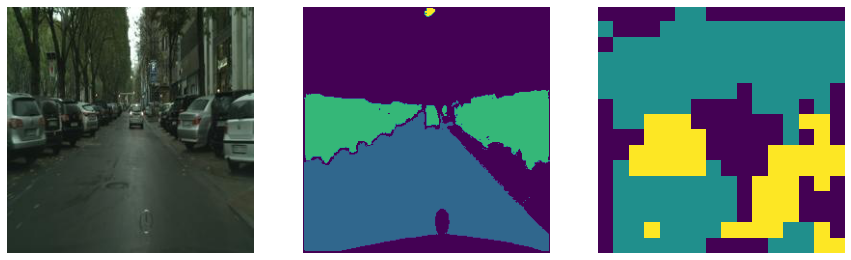


Sample Prediction after epoch 52

13/12 [===============================] - 14s 1s/step - loss: 0.3685 - n22_conv1_1x1_loss: 0.1979 - aux_22_loss: 0.2540 - aux_12_loss: 0.4314 - n22_conv1_1x1_accuracy: 0.9118 - aux_22_accuracy: 0.8908 - aux_12_accuracy: 0.8512 - val_loss: 4.6958 - val_n22_conv1_1x1_loss: 4.1629 - val_aux_22_loss: 0.9684 - val_aux_12_loss: 0.9090 - val_n22_conv1_1x1_accuracy: 0.1724 - val_aux_22_accuracy: 0.6452 - val_aux_12_accuracy: 0.6929
Epoch 53/200
13/12 [===============================] - ETA: 0s - loss: 0.3714 - n22_conv1_1x1_loss: 0.1984 - aux_22_loss: 0.2569 - aux_12_loss: 0.4384 - n22_conv1_1x1_accuracy: 0.9125 - aux_22_accuracy: 0.8901 - aux_12_accuracy: 0.8452

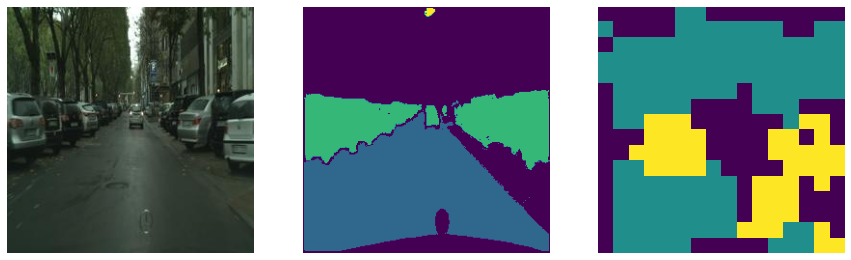


Sample Prediction after epoch 53

13/12 [===============================] - 14s 1s/step - loss: 0.3714 - n22_conv1_1x1_loss: 0.1984 - aux_22_loss: 0.2569 - aux_12_loss: 0.4384 - n22_conv1_1x1_accuracy: 0.9125 - aux_22_accuracy: 0.8901 - aux_12_accuracy: 0.8452 - val_loss: 1.3552 - val_n22_conv1_1x1_loss: 0.8734 - val_aux_22_loss: 0.8533 - val_aux_12_loss: 0.8780 - val_n22_conv1_1x1_accuracy: 0.6547 - val_aux_22_accuracy: 0.6807 - val_aux_12_accuracy: 0.7123
Epoch 54/200
13/12 [===============================] - ETA: 0s - loss: 0.3566 - n22_conv1_1x1_loss: 0.1900 - aux_22_loss: 0.2479 - aux_12_loss: 0.4215 - n22_conv1_1x1_accuracy: 0.9143 - aux_22_accuracy: 0.8919 - aux_12_accuracy: 0.8518

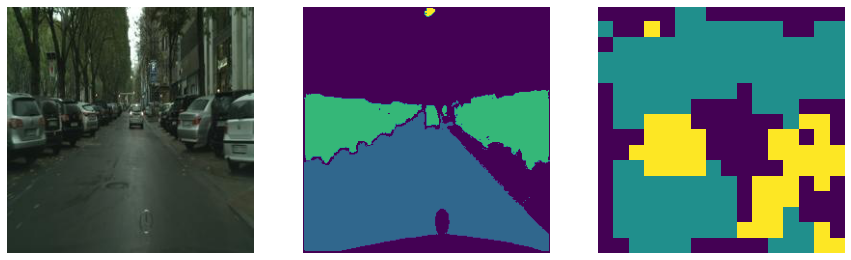


Sample Prediction after epoch 54

13/12 [===============================] - 15s 1s/step - loss: 0.3566 - n22_conv1_1x1_loss: 0.1900 - aux_22_loss: 0.2479 - aux_12_loss: 0.4215 - n22_conv1_1x1_accuracy: 0.9143 - aux_22_accuracy: 0.8919 - aux_12_accuracy: 0.8518 - val_loss: 1.9628 - val_n22_conv1_1x1_loss: 1.5219 - val_aux_22_loss: 0.7595 - val_aux_12_loss: 0.8573 - val_n22_conv1_1x1_accuracy: 0.6143 - val_aux_22_accuracy: 0.7073 - val_aux_12_accuracy: 0.7212
Epoch 55/200
13/12 [===============================] - ETA: 0s - loss: 0.3500 - n22_conv1_1x1_loss: 0.1873 - aux_22_loss: 0.2443 - aux_12_loss: 0.4065 - n22_conv1_1x1_accuracy: 0.9169 - aux_22_accuracy: 0.8952 - aux_12_accuracy: 0.8553

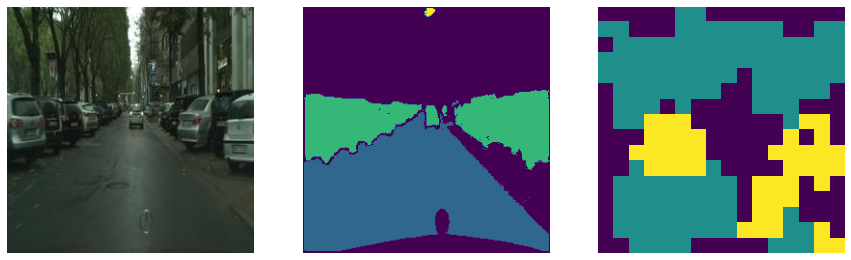


Sample Prediction after epoch 55

13/12 [===============================] - 14s 1s/step - loss: 0.3500 - n22_conv1_1x1_loss: 0.1873 - aux_22_loss: 0.2443 - aux_12_loss: 0.4065 - n22_conv1_1x1_accuracy: 0.9169 - aux_22_accuracy: 0.8952 - aux_12_accuracy: 0.8553 - val_loss: 1.2785 - val_n22_conv1_1x1_loss: 0.8624 - val_aux_22_loss: 0.7047 - val_aux_12_loss: 0.8391 - val_n22_conv1_1x1_accuracy: 0.6351 - val_aux_22_accuracy: 0.7227 - val_aux_12_accuracy: 0.7349
Epoch 56/200
13/12 [===============================] - ETA: 0s - loss: 0.3763 - n22_conv1_1x1_loss: 0.2047 - aux_22_loss: 0.2606 - aux_12_loss: 0.4212 - n22_conv1_1x1_accuracy: 0.9112 - aux_22_accuracy: 0.8894 - aux_12_accuracy: 0.8528

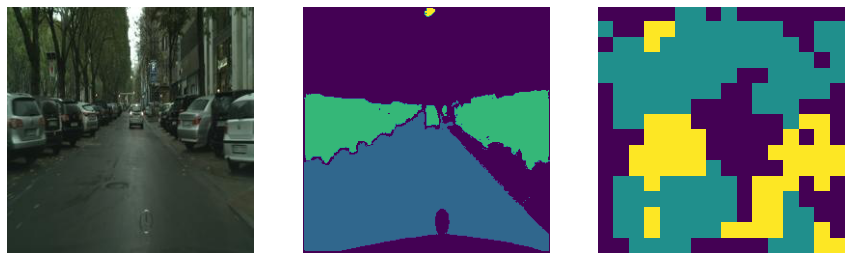


Sample Prediction after epoch 56

13/12 [===============================] - 14s 1s/step - loss: 0.3763 - n22_conv1_1x1_loss: 0.2047 - aux_22_loss: 0.2606 - aux_12_loss: 0.4212 - n22_conv1_1x1_accuracy: 0.9112 - aux_22_accuracy: 0.8894 - aux_12_accuracy: 0.8528 - val_loss: 1.1815 - val_n22_conv1_1x1_loss: 0.7806 - val_aux_22_loss: 0.6646 - val_aux_12_loss: 0.8445 - val_n22_conv1_1x1_accuracy: 0.6766 - val_aux_22_accuracy: 0.7354 - val_aux_12_accuracy: 0.7412
Epoch 57/200
13/12 [===============================] - ETA: 0s - loss: 0.3514 - n22_conv1_1x1_loss: 0.1888 - aux_22_loss: 0.2446 - aux_12_loss: 0.4045 - n22_conv1_1x1_accuracy: 0.9159 - aux_22_accuracy: 0.8933 - aux_12_accuracy: 0.8542

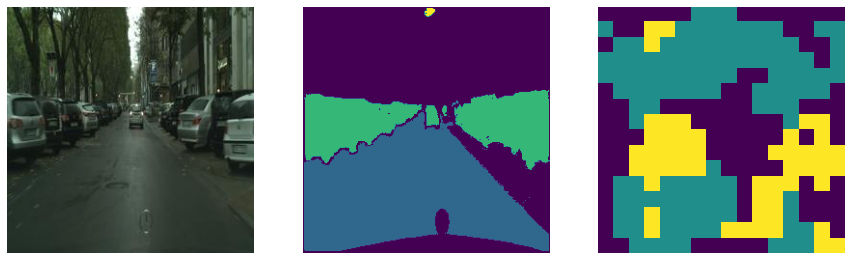


Sample Prediction after epoch 57

13/12 [===============================] - 14s 1s/step - loss: 0.3514 - n22_conv1_1x1_loss: 0.1888 - aux_22_loss: 0.2446 - aux_12_loss: 0.4045 - n22_conv1_1x1_accuracy: 0.9159 - aux_22_accuracy: 0.8933 - aux_12_accuracy: 0.8542 - val_loss: 1.2982 - val_n22_conv1_1x1_loss: 0.9020 - val_aux_22_loss: 0.6551 - val_aux_12_loss: 0.8388 - val_n22_conv1_1x1_accuracy: 0.6573 - val_aux_22_accuracy: 0.7418 - val_aux_12_accuracy: 0.7375
Epoch 58/200
13/12 [===============================] - ETA: 0s - loss: 0.3571 - n22_conv1_1x1_loss: 0.1923 - aux_22_loss: 0.2501 - aux_12_loss: 0.4048 - n22_conv1_1x1_accuracy: 0.9148 - aux_22_accuracy: 0.8919 - aux_12_accuracy: 0.8537

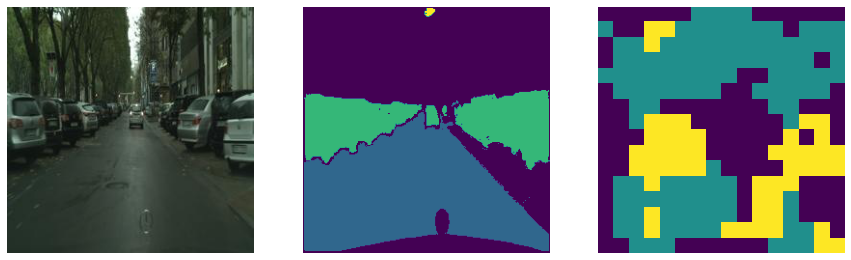


Sample Prediction after epoch 58

13/12 [===============================] - 15s 1s/step - loss: 0.3571 - n22_conv1_1x1_loss: 0.1923 - aux_22_loss: 0.2501 - aux_12_loss: 0.4048 - n22_conv1_1x1_accuracy: 0.9148 - aux_22_accuracy: 0.8919 - aux_12_accuracy: 0.8537 - val_loss: 1.1605 - val_n22_conv1_1x1_loss: 0.7735 - val_aux_22_loss: 0.6359 - val_aux_12_loss: 0.8290 - val_n22_conv1_1x1_accuracy: 0.6828 - val_aux_22_accuracy: 0.7534 - val_aux_12_accuracy: 0.7521
Epoch 59/200
13/12 [===============================] - ETA: 0s - loss: 0.3599 - n22_conv1_1x1_loss: 0.1944 - aux_22_loss: 0.2530 - aux_12_loss: 0.4020 - n22_conv1_1x1_accuracy: 0.9140 - aux_22_accuracy: 0.8912 - aux_12_accuracy: 0.8530

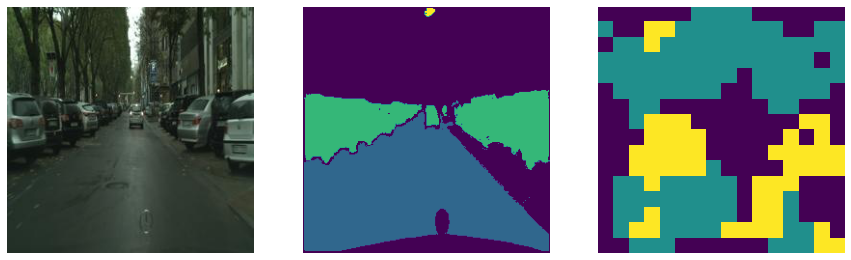


Sample Prediction after epoch 59

13/12 [===============================] - 14s 1s/step - loss: 0.3599 - n22_conv1_1x1_loss: 0.1944 - aux_22_loss: 0.2530 - aux_12_loss: 0.4020 - n22_conv1_1x1_accuracy: 0.9140 - aux_22_accuracy: 0.8912 - aux_12_accuracy: 0.8530 - val_loss: 1.2705 - val_n22_conv1_1x1_loss: 0.8849 - val_aux_22_loss: 0.6285 - val_aux_12_loss: 0.8386 - val_n22_conv1_1x1_accuracy: 0.7016 - val_aux_22_accuracy: 0.7572 - val_aux_12_accuracy: 0.7496
Epoch 60/200
13/12 [===============================] - ETA: 0s - loss: 0.3532 - n22_conv1_1x1_loss: 0.1908 - aux_22_loss: 0.2461 - aux_12_loss: 0.3996 - n22_conv1_1x1_accuracy: 0.9163 - aux_22_accuracy: 0.8939 - aux_12_accuracy: 0.8599

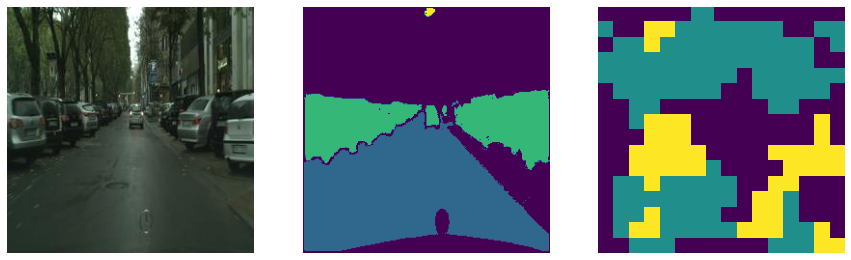


Sample Prediction after epoch 60

13/12 [===============================] - 14s 1s/step - loss: 0.3532 - n22_conv1_1x1_loss: 0.1908 - aux_22_loss: 0.2461 - aux_12_loss: 0.3996 - n22_conv1_1x1_accuracy: 0.9163 - aux_22_accuracy: 0.8939 - aux_12_accuracy: 0.8599 - val_loss: 1.6653 - val_n22_conv1_1x1_loss: 1.2797 - val_aux_22_loss: 0.6239 - val_aux_12_loss: 0.8502 - val_n22_conv1_1x1_accuracy: 0.5848 - val_aux_22_accuracy: 0.7632 - val_aux_12_accuracy: 0.7508
Epoch 61/200
13/12 [===============================] - ETA: 0s - loss: 0.3619 - n22_conv1_1x1_loss: 0.1967 - aux_22_loss: 0.2517 - aux_12_loss: 0.4034 - n22_conv1_1x1_accuracy: 0.9137 - aux_22_accuracy: 0.8900 - aux_12_accuracy: 0.8544

In [0]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    #clear_output()
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

EPOCHS = 200
STEPS_PER_EPOCH = num_images / BATCH_SIZE
VAL_SUBSPLITS = 5
VALIDATION_STEPS = 100 # info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

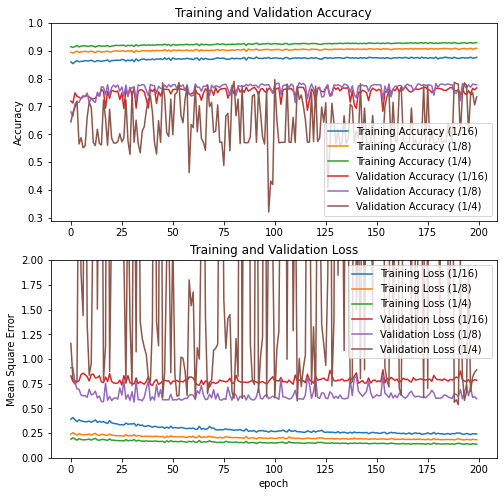

In [22]:
# Learning curves
print(model_history)
aux_12_acc = model_history.history['aux_12_accuracy']
aux_22_acc = model_history.history['aux_22_accuracy']
n22_acc    = model_history.history['n22_conv1_1x1_accuracy']

val_aux_12_acc = model_history.history['val_aux_12_accuracy']
val_aux_22_acc = model_history.history['val_aux_22_accuracy']
val_n22_acc    = model_history.history['val_n22_conv1_1x1_accuracy']


aux_12_loss = model_history.history['aux_12_loss']
aux_22_loss = model_history.history['aux_22_loss']
n22_loss    = model_history.history['n22_conv1_1x1_loss']

val_aux_12_loss = model_history.history['val_aux_12_loss']
val_aux_22_loss = model_history.history['val_aux_22_loss']
val_n22_loss    = model_history.history['val_n22_conv1_1x1_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(aux_12_acc, label='Training Accuracy (1/16)')
plt.plot(aux_22_acc, label='Training Accuracy (1/8)')
plt.plot(n22_acc, label='Training Accuracy (1/4)')

plt.plot(val_aux_12_acc, label='Validation Accuracy (1/16)')
plt.plot(val_aux_22_acc, label='Validation Accuracy (1/8)')
plt.plot(val_n22_acc, label='Validation Accuracy (1/4)')

plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(aux_12_loss, label='Training Loss (1/16)')
plt.plot(aux_22_loss, label='Training Loss (1/8)')
plt.plot(n22_loss, label='Training Loss (1/4)')

plt.plot(val_aux_12_loss, label='Validation Loss (1/16)')
plt.plot(val_aux_22_loss, label='Validation Loss (1/8)')
plt.plot(val_n22_loss, label='Validation Loss (1/4)')

plt.legend(loc='upper right')
plt.ylabel('Mean Square Error')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()